# Modeling

In [87]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LogisticRegression

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)
%matplotlib inline

In [88]:
cases = pd.read_csv('Data.nosync/Similar_TM.csv')
cases.sample(20)

TM_A                       TM_B  target
328                   MOBE                   MOBICARD       0
378         MONSTER ENERGY                    MONSTER       1
234      Knockout Clothing                  KNOCK OUT       1
364              WRIGLEY’S    Wrigleys drinks company       1
262                 SIMTEK                     SIMTEC       1
310             Casablanca  Weekend in Casablanca Tea       0
71               Eden Pure            Eden Aesthetics       1
171    Together for Better        All Together Better       1
249                   ERES                       ERIS       1
287                Up-town                       7-up       0
419              LION HEAD                 TRIPL LION       0
267                   VION                      VIFON       1
220              Artigiano         Espresso Artigiano       1
105               SYNDIKAT                  SYNDICATE       1
207                 VESPER                    VESPERS       1
231               ESSENTRA                    ESSENTA       1
361           CAMEL ACTIVE                 Camel Capa       1
38                 EMOLITE                    EDOMIGE       1
85                   The W                 THE W CLUB       1
31   The University of Law                       ULAW       1

In [89]:
import unidecode
from fuzzywuzzy import fuzz
import jellyfish

from abydos.distance import (IterativeSubString, BISIM, DiscountedLevenshtein, Prefix, LCSstr, MLIPNS, Strcmp95,
MRA, Editex, SAPS, FlexMetric, JaroWinkler, HigueraMico, Sift4, Eudex, ALINE, PhoneticEditDistance)

from abydos.phonetic import PSHPSoundexFirst, Ainsworth
pshp_soundex_first = PSHPSoundexFirst()
pe = Ainsworth()

In [90]:
iss = IterativeSubString()
bisim = BISIM()
dlev = DiscountedLevenshtein()
prefix = Prefix()
lcs = LCSstr()
mlipns = MLIPNS()
strcmp95 = Strcmp95()
mra = MRA()
editex = Editex()
saps = SAPS()
flexmetric = FlexMetric()
jaro = JaroWinkler(mode='Jaro')
higuera_mico = HigueraMico()
sift4 = Sift4()
eudex = Eudex()
aline = ALINE()
phonetic_edit = PhoneticEditDistance()

In [91]:
algos = [iss, bisim, dlev, prefix, lcs, mlipns, strcmp95, mra, editex, saps, flexmetric, jaro, higuera_mico, sift4, eudex,
         aline, phonetic_edit]

algo_names = ['iterativesubstring', 'bisim', 'discountedlevenshtein', 'prefix', 'lcsstr', 'mlipns', 'strcmp95', 'mra',
              'editex', 'saps', 'flexmetric', 'jaro', 'higueramico', 'sift4', 'eudex', 'aline',
              'phoneticeditdistance']

In [92]:
from abydos.phones import *

In [93]:
def sum_ipa(name_a, name_b):
    feat1 = ipa_to_features(pe.encode(name_a))
    feat2 = ipa_to_features(pe.encode(name_b))
    if len(feat1) <= 1:
        score = sum(cmp_features(f1, f2) for f1, f2 in zip(feat1, feat2))/1
    else:    
        score = sum(cmp_features(f1, f2) for f1, f2 in zip(feat1, feat2))/len(feat1)
    return score

In [94]:
import re

In [95]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

def featurize(df):
    if len(df.columns)==3:
        df.columns=['a', 'b', 'target']
    elif len(df.columns)==2:
        df.columns=['a', 'b']
    else:
        df = df.rename(columns={df.columns[0]: 'a', df.columns[1]: 'b' })
        
    df['TM_A'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['a']).lower()), axis=1)
    df['TM_B'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['b']).lower()), axis=1)
    
    df['partial'] = df.apply(lambda row: fuzz.partial_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_sort'] = df.apply(lambda row: fuzz.token_sort_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_set'] = df.apply(lambda row: fuzz.token_set_ratio(row.TM_A,row.TM_B), axis=1)
    
    df['sum_ipa'] = df.apply(lambda row: sum_ipa(row.TM_A,row.TM_B), axis=1)
    
    # Jellyfish levenshtein
    df['levenshtein']= df.apply(lambda row: jellyfish.levenshtein_distance(row.TM_A,row.TM_B), axis=1)
    # Scale Levenshtein column
    scaler = MinMaxScaler()
    df['levenshtein'] = scaler.fit_transform(df['levenshtein'].values.reshape(-1,1))

    # Jellyfish phoneme
    df['metaphone'] = df.apply(
        lambda row: 1 if jellyfish.metaphone(row.TM_A)==jellyfish.metaphone(row.TM_B) else 0, axis=1)
    df['nysiis'] = df.apply(
        lambda row: 1 if jellyfish.nysiis(row.TM_A)==jellyfish.nysiis(row.TM_B) else 0, axis=1)
    df['mtch_rtng_cdx'] = df.apply(
        lambda row: 1 if jellyfish.match_rating_codex(row.TM_A)==jellyfish.match_rating_codex(row.TM_B) else 0, axis=1)
    
    df['pshp_soundex_first'] = df.apply(
        lambda row: 1 if pshp_soundex_first.encode(row.TM_A)==pshp_soundex_first.encode(row.TM_B) else 0, axis=1)
    
    for i, algo in enumerate(algos):
            df[algo_names[i]] = df.progress_apply(lambda row: algo.sim(row.TM_A, row.TM_B), axis=1)

    
    return df

In [96]:
# featurize(cases)

### Class Balancing  
We can see that the classes are imbalanced, there are more instances of trademark invalidation than are dismissals.

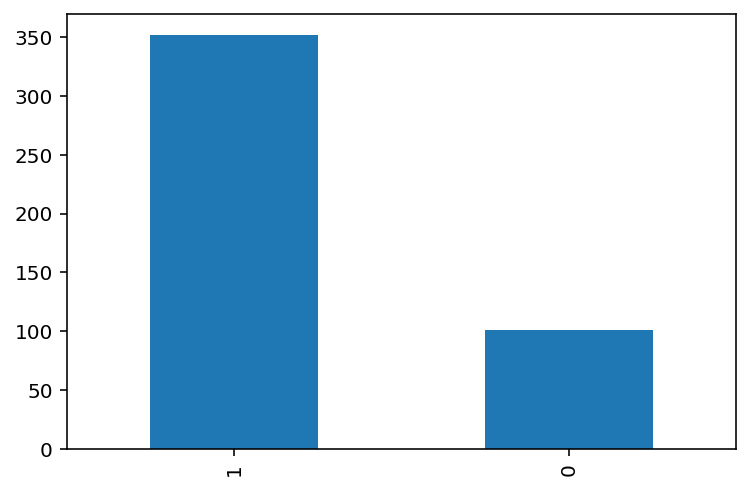

In [97]:
cases['target'].value_counts()[:2].plot(kind='bar')

# plt.savefig('TM_Unbalanced.png', dpi = 300)

In [98]:
from itertools import combinations
import random
random.seed(42)


In [99]:
# Use combinatorics to generate negative class
pos_cases = cases[cases['target'] == 1]

case_names = pos_cases.loc[:, 'TM_A':'TM_B'].values.tolist()
unique_cases = list(set([item for items in case_names for item in items]))
alt_pairs = list(zip(pos_cases.TM_A, pos_cases.TM_B))+ list(zip(pos_cases.TM_B, pos_cases.TM_A))
comb = list(combinations(unique_cases, 2))
nonmatch_cases = list(set(comb) - set(alt_pairs))
# Undersample the negative class for 1:4 class imbalance instead of 1:1000 extreme class imbalance
nonmatch_cases = pd.DataFrame(random.choices(nonmatch_cases, k=250), columns=['TM_A', 'TM_B']) # Originally was 1200

nonmatch_cases

TM_A             TM_B
0                    CIRQUIT  SEARCH SAVVY PR
1                   EASYSAIL             IFIS
2                    RELATED     + Class View
3                   Easypack            ANNKE
4                   RAWPIXEL         FINASTRA
..                       ...              ...
245               THE BUBBLE      PINGPERFECT
246                 RAWPIXEL           Kresco
247  CITIGATE COMMUNICATIONS            STONE
248                     WAGO  Horse of London
249         CHEVRON HERITAGE            Point

[250 rows x 2 columns]

In [100]:
print('positive class ratio 1:{}'.format(int(len(nonmatch_cases)/len(pos_cases))))

positive class ratio 1:0


In [101]:
nonmatch_cases.sample(20)

TM_A                 TM_B
182                                Zero              ANIMAL.
65                            FENESTRAE                   C3
49                             Sambucks                 JUST
175                          ALPHA GOLD  LOREN TAYLOR LONDON
68          Woodman’s Business Services             Untangle
34                            LIFESTYLE           ISY IMARNI
0                               CIRQUIT      SEARCH SAVVY PR
166                               SEVEN           BRAINWAVES
87                            LOS PICOS             AMINORED
160                           MEDI HERB                Alair
219                              RAWKUS               J WELL
198                               VEYPE            ICE SWISS
44                              Newport       All Star Lanes
200                          DiamondPay           Supersonic
22                                ZEGNA          CONNECT.COM
79                                ZEGNA         CAMEL ACTIVE
179                       Platinum Plus           Tailor-Tee
51                                  Be.              MOSCANY
47   Canvas Lifestyle Retirement Living          Sporti Tots
122                                  BE            OPTRONICS

In [102]:
# Negative Class
nonmatch_cases['target'] = 0
df = pd.concat([pos_cases, nonmatch_cases])
# non_match_cases = None
# pos_cases = None

# Add true negatives
neg_cases = cases[cases['target'] == 0]
class_balanced = pd.concat([df, neg_cases])

class_balanced.sample(20)

# class_balanced[class_balanced['TM_B'].str.len()!=0]


TM_A  \
234                                        Zlide   
30                                          GURU   
155                                         IFIS   
317        Raw Passion Organic & Vegan Skin Food   
42   The Oxford Centre for Christian Apologetics   
147                                          PIP   
27                                  smartworking   
394                                   My Cat Pip   
306                                         SNUP   
341                                          MOP   
187                                        GENIE   
135                                      CIRCUIT   
389                                     INTABALL   
421                          Richmond Decoration   
79                                         ZEGNA   
243                                      PROGAIN   
450                                       CHIQUO   
88                                 Fizz Fitness    
217                           ALEXANDER OF PARIS   
149                                   MONSTAVAPE   

                               TM_B  target  
234                     Harry’s Bar       0  
30                         LECIPHOL       0  
155                             FIS       1  
317                             RAW       0  
42             University of Oxford       1  
147                     PINGPERFECT       0  
27                          Trucool       0  
394                             PIP       1  
306                            Snub       0  
341                             AMQ       0  
187                       JOBZGENIE       1  
135          Galaxy Print Finishing       0  
389                            INTA       1  
421  RICHMOND DESIGNING HOSPITALITY       0  
79                     CAMEL ACTIVE       0  
243                       PRO GAINS       1  
450                            CHIO       0  
88   MARAS DONDUMAYI ADIYLA ISTEVIN       0  
217              ALEXANDRE DE PARIS       1  
149                  MONSTER ENERGY       1

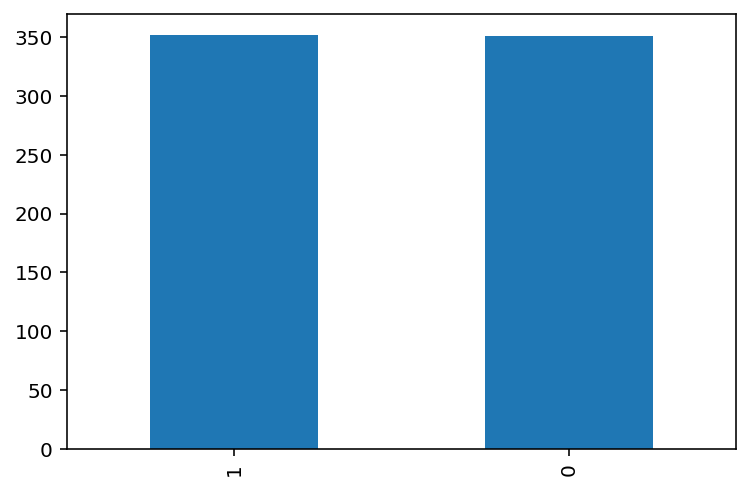

In [103]:
class_balanced['target'].value_counts()[:2].plot(kind='bar')

# plt.savefig('TM_Balanced.png', dpi = 300)

In [104]:
from tqdm.autonotebook import tqdm
tqdm.pandas()

df = featurize(class_balanced)
df.sample(20)

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version


a                           b  target  \
71              Eden Pure             Eden Aesthetics       1   
249      CHEVRON HERITAGE                       Point       0   
248                EPONIM                       PONIM       1   
303                   CME                   IRSIA CMF       0   
326       MARK ADAMS NO 1                     MARK 10       0   
105      CHEVRON HERITAGE        University of Oxford       0   
53      FEDERICO IGUZZINI                smartworking       0   
74                   AURA                     Simoniz       0   
49       Harleydietitians               Harley Clinic       1   
167                  LOCO                        LOKA       1   
47                   IQOS                         QIS       1   
37       THE ICECREAMISTS                      Dyflex       0   
40               PURE IPR                   Starbucks       0   
148  GIRAFFE & HOBBIT LTD                     SKYCLAD       0   
245                 ANNAS                        AMMA       1   
161                  DG’S                  DG FASHION       1   
172   Suisman and Shapiro                 Bridgestone       0   
403               THOMSON  BELGRAVES A THOMPSON HOTEL       1   
193                   RAW                    RAWPIXEL       1   
58              Vaporized                    CASTELLI       0   

                  TM_A                     TM_B  partial  tkn_sort  tkn_set  \
71            edenpure           edenaesthetics       62        45       45   
249    chevronheritage                    point       40        30       30   
248             eponim                    ponim      100        91       91   
303                cme                 irsiacmf       67        36       36   
326        markadamsno                     mark      100        53       53   
105    chevronheritage       universityofoxford       33        30       30   
53    federicoiguzzini             smartworking       33        29       29   
74                aura                  simoniz        0         0        0   
49    harleydietitians             harleyclinic       67        57       57   
167               loco                     loka       50        50       50   
47                iqos                      qis       67        57       57   
37     theicecreamists                   dyflex       17        10       10   
40             pureipr                starbucks       14        12       12   
148   giraffehobbitltd                  skyclad       29        17       17   
245              annas                     amma       50        44       44   
161                dgs                dgfashion       67        50       50   
172  suismanandshapiro              bridgestone       27        29       29   
403            thomson  belgravesathompsonhotel       86        47       47   
193                raw                 rawpixel      100        55       55   
58           vaporized                 castelli       25        24       24   

      sum_ipa  levenshtein  metaphone  nysiis  mtch_rtng_cdx  \
71   0.881048     0.290323          0       0              0   
249  0.264516     0.419355          0       0              0   
248  0.481183     0.032258          0       0              0   
303  0.741935     0.193548          0       0              0   
326  0.272727     0.225806          0       0              0   
105  0.735484     0.516129          0       0              0   
53   0.473435     0.387097          0       0              0   
74   0.553763     0.225806          0       0              0   
49   0.552419     0.258065          0       0              0   
167  0.951613     0.064516          1       1              0   
47   0.525806     0.064516          0       0              0   
37   0.477667     0.451613          0       0              0   
40   0.778802     0.258065          0       0              0   
148  0.306452     0.451613          0       0              0   
245  0.735484     0.096774          0 

#### Export clean data to csv

In [105]:
# df.to_csv('Data.nosync/TM_features.csv', index=False)  

In [106]:
y = df.target
X = df.drop(columns = 'target')

X
y

0      1
1      1
2      1
3      1
4      1
      ..
437    0
444    0
445    0
446    0
450    0
Name: target, Length: 703, dtype: int64

In [107]:
from sklearn.model_selection import train_test_split

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train

a                           b  \
165                   DRIVEONE                 DRIVEON.NET   
234          Knockout Clothing                   KNOCK OUT   
358              FABER-CASTELL                    CASTELLI   
266           WILDWOOD KITCHEN  WILD AND WOOD COFFEE HOUSE   
110                GLENFIDDICH                   Glenfield   
..                         ...                         ...   
71                   Eden Pure             Eden Aesthetics   
106                SOHO GARDEN                  SOHO HOUSE   
271  SHAPING THE WORLD OF WORK  POWERING THE WORLD OF WORK   
83                      ANIMAL                   SOUP’D UP   
102                Shortlyster                 Shortlister   

                      TM_A                    TM_B  partial  tkn_sort  \
165               driveone              driveonnet       88        89   
234       knockoutclothing                knockout      100        67   
358           fabercastell                castelli       93        70   
266        wildwoodkitchen  wildandwoodcoffeehouse       60        59   
110            glenfiddich               glenfield       78        70   
..                     ...                     ...      ...       ...   
71                edenpure          edenaesthetics       62        45   
106             sohogarden               sohohouse       56        53   
271  shapingtheworldofwork  poweringtheworldofwork       81        84   
83                  animal                 soupdup        0         0   
102            shortlyster             shortlister       91        91   

     tkn_set   sum_ipa  levenshtein  metaphone  nysiis  mtch_rtng_cdx  \
165       89  1.000000     0.064516          0       0              0   
234       67  0.461538     0.258065          0       0              0   
358       70  0.424731     0.193548          0       0              0   
266       59  0.833333     0.419355          0       0              0   
110       70  0.763930     0.161290          0       0              0   
..       ...       ...          ...        ...     ...            ...   
71        45  0.881048     0.290323          0       0              0   
106       53  0.740143     0.161290          0       0              0   
271       84  0.703735     0.161290          0       0              0   
83         0  0.672043     0.225806          0       0              0   
102       91  1.000000     0.032258          1       0              1   

     pshp_soundex_first  iterativesubstring     bisim  discountedlevenshtein  \
165                   1            0.908499  0.800000               0.849190   
234                   1            0.900000  0.500000               0.614836   
358                   0            0.817277  0.541667               0.457015   
266                   0            0.668757  0.454545               0.498841   
110                   1            0.791348  0.636364               0.646030   
..                  ...                 ...       ...                    ...   
71                    0            0.619697  0.357143               0.457191   
106                   1            0.646890  0.500000               0.581428   
271                   0            0.866480  0.772727               0.651004   
83                    0            0.000000  0.000000               0.000000   
102                   1            0.966554  0.909091               0.922197   

       prefix    lcsstr  mlipns  strcmp95       mra    editex      saps  \
165  0.875000  0.700000     1.0  0.960000  0.833333  0.900000  0.866667   
234  1.000000  0.500000     0.0  0.900000  0.500000  0.531250  0.137255   
358  0.000000  0.583333     0.0  0.745040  0.500000  0.500000  0.324324   
266  0.266667  0.227273     0.0  0.825818  0.666667  0.590909  0.209677   
110  0.666667  0.545455     0.0  0.894949  0.500000  0.681818  0.555556   
..        ...       ...     ...       ...       ...       ...       ...   
71   0.500000  0.285714     0.0  0.680357  0

In [109]:
#X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1)

## TPOT AutoML pipeline

In [110]:
from tpot import TPOTClassifier

In [111]:
# pipeline_optimizer = TPOTClassifier(
#         scoring = 'f1', 
#         generations=100,
#         verbosity=2,
#         n_jobs=-1   # Utilizes all available CPU cores
#         ) 
# pipeline_optimizer.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train)

In [112]:
# print(pipeline_optimizer.score(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_test))

### Export TPOT pipeline

In [113]:
# pipeline_optimizer.export('tpot_exported_calssifier_pipeline.py')

### Load TPOT pipeline

In [114]:
df_TPOT = df.drop(columns = ['a','b','TM_A','TM_B'])
df_TPOT

target  partial  tkn_sort  tkn_set   sum_ipa  levenshtein  metaphone  \
0         1       57        50       50  0.658986     0.161290          0   
1         1       38        38       38  0.691532     0.161290          0   
2         1       89        73       73  0.806452     0.096774          0   
3         1       83        83       83  0.895161     0.096774          0   
4         1       74        65       65  0.743176     0.290323          0   
..      ...      ...       ...      ...       ...          ...        ...   
437       0       62        43       43  0.905242     0.483871          0   
444       0       80        73       73  0.925806     0.064516          0   
445       0      100        83       83  0.488479     0.064516          0   
446       0      100        80       80  0.615385     0.129032          0   
450       0       75        80       80  0.516129     0.064516          0   

     nysiis  mtch_rtng_cdx  pshp_soundex_first  iterativesubstring     bisim  \
0         0              0                   0            0.485480  0.388889   
1         0              0                   0            0.050000  0.437500   
2         0              0                   0            0.821263  0.583333   
3         0              0                   1            0.884677  0.833333   
4         0              0                   0            0.951613  0.588235   
..      ...            ...                 ...                 ...       ...   
437       0              0                   1            0.577381  0.275000   
444       0              0                   1            0.875809  0.750000   
445       0              0                   0            0.916667  0.642857   
446       0              0                   1            0.940000  0.666667   
450       0              0                   0            0.786471  0.583333   

     discountedlevenshtein  prefix    lcsstr  mlipns  strcmp95       mra  \
0                 0.383752   0.000  0.333333     0.0  0.722751  0.666667   
1                 0.366778   0.125  0.250000     0.0  0.633333  0.500000   
2                 0.495199   0.000  0.666667     0.0  0.822222  0.833333   
3                 0.818487   0.750  0.750000     1.0  0.933333  0.500000   
4                 0.472052   0.000  0.529412     0.0  0.700700  0.000000   
..                     ...     ...       ...     ...       ...       ...   
437               0.368095   0.500  0.200000     0.0  0.625000  0.000000   
444               0.732861   0.800  0.666667     1.0  0.915333  0.833333   
445               0.664079   0.000  0.714286     0.0  0.904762  0.833333   
446               0.750388   1.000  0.666667     1.0  0.933333  0.500000   
450               0.708712   0.750  0.500000     1.0  0.922222  0.833333   

       editex      saps  flexmetric      jaro  higueramico     sift4  \
0    0.555556  0.137931    0.566667  0.671958     0.430556  0.444444   
1    0.500000  0.304348    0.400000  0.583333     0.375000  0.375000   
2    0.500000  0.428571    0.600000  0.822222     0.547619  0.666667   
3    0.833333  0.666667    0.833333  0.888889     0.769231  0.833333   
4    0.588235  0.319149    0.538235  0.687675     0.490372  0.588235   
..        ...       ...         ...       ...          ...       ...   
437  0.275000  0.000000    0.417500  0.625000     0.000000  0.250000   
444  0.750000  0.476190    0.691667  0.822222     0.666667  0.666667   
445  0.714286  0.500000    0.800000  0.904762     0.690476  0.714286   
446  0.666667  0.476190    0.708333  0.888889     0.614646  0.666667   
450  0.666667  0.476190    0.683333  0.888889     0.633333  0.666667   

        eudex     aline  phoneticeditdistance  
0    0.654902  0.602128              0.727599  
1    0.916667  0.545455              0.897177  
2    0.786275  0.705882              0.634409  
3    1.000000  0.873529              0.913978  
4    0.463725  0.589655              0.646110  
..        ...       ...                   ...  
437  

In [115]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = df_TPOT
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: 0.8945711361541637
exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    GradientBoostingClassifier(learning_rate=0.01, max_depth=3, max_features=0.5,
                               min_samples_leaf=10, min_samples_split=3, 
                               n_estimators=100, subsample=0.9500000000000001)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

results

array([1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [116]:
def base_model_1(X_train, y_train, X_test, export = False) :
    exported_pipeline = make_pipeline(
    GradientBoostingClassifier(
        learning_rate=0.01, 
        max_depth=3, max_features=0.5,
        min_samples_leaf=10, min_samples_split=3, 
        n_estimators=100, subsample=0.9500000000000001)
    )

    exported_pipeline.fit(X_train, y_train)
    if export==True:
        return exported_pipeline
    else:
        y_pred = exported_pipeline.predict_proba(X_test)
        return [p[1] for p in y_pred]

In [117]:
base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), 
             y_train, X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

[0.19647620492402026,
 0.6863138066148419,
 0.7383104992504111,
 0.19056468311682315,
 0.6652043242746805,
 0.23990766915016615,
 0.19369228622931514,
 0.6561635342802297,
 0.19056468311682315,
 0.5668917589091245,
 0.19056468311682315,
 0.6495388435783042,
 0.21195302630139698,
 0.19056468311682315,
 0.5909295068916293,
 0.6850217671666007,
 0.7312682453576278,
 0.654489512793498,
 0.6640983645928661,
 0.6836242339358968,
 0.19056468311682315,
 0.6608685464810262,
 0.19056468311682315,
 0.19056468311682315,
 0.19056468311682315,
 0.39823782989144113,
 0.7015171400875457,
 0.19056468311682315,
 0.6868635929088438,
 0.6586150244828964,
 0.6428736637997737,
 0.6746092445274022,
 0.7207129161931373,
 0.7331956585751239,
 0.19369228622931514,
 0.6650049639379741,
 0.7247562645012643,
 0.5585712569337515,
 0.19221424572682483,
 0.19302519144349944,
 0.5810367824734509,
 0.7396904454149573,
 0.2098296676157106,
 0.27971792185173244,
 0.6180900844653827,
 0.5499885153339914,
 0.19056468311682

# K-fold cross validation

In [118]:
from sklearn.model_selection import StratifiedKFold

In [119]:
pd.options.mode.chained_assignment = None

# Stratified K-Folds cross-validator
meta_training = pd.DataFrame()

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

fold = 1
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    oof_pred = X_test[['TM_A', 'TM_B']]
    
    oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
                                      y_train,
                                      X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
    
    oof_pred['target'] = y_test.tolist()
    
    print('completed fold {} of 10'.format(fold))
    fold += 1

    meta_training = meta_training.append(oof_pred)

completed fold 1 of 10
completed fold 2 of 10
completed fold 3 of 10
completed fold 4 of 10
completed fold 5 of 10
completed fold 6 of 10
completed fold 7 of 10
completed fold 8 of 10
completed fold 9 of 10
completed fold 10 of 10


In [120]:
meta_training.sample(20)

TM_A                         TM_B  predict_proba  target
102          intaball                        verve       0.190065       0
51           halloumi                hajduhalloumi       0.711635       1
433         happymeal              happysandwiches       0.716268       1
218      kingscollege                       lumene       0.196129       0
32              tommy                            k       0.225008       0
209         doctornow                        drnow       0.682540       1
98           percipio             redbullbbqgrills       0.195277       0
289  thehydeparkdygin               hydeparkcorner       0.689425       0
128     campuselysium              britishgreengas       0.195277       0
122              guru                  contentguru       0.645199       1
441        galatopoly                     monopoly       0.655261       1
356           erelief                  lightrelief       0.714475       0
139       canvashomes              canvaslifestyle       0.654759       1
272           iceland                    icelander       0.710614       1
144  giraffehobbitltd                 truetraveler       0.190065       0
88        fizzfitness  marasdondumayiadiylaistevin       0.195947       0
182       wealthsmart               ubssmartwealth       0.507185       1
113        fashiontan                          sky       0.194131       0
123       milltronics                        dylan       0.196256       0
236              womo                 momofashions       0.499755       1

### Meta-Model: Logistic Regression

In [121]:
df=featurize(meta_training)

In [122]:
df.sample(20)

a               b  predict_proba  target  \
270              urbanfox             fox       0.634407       1   
293              eezeevet  easipetcareltd       0.315057       0   
123             addiction  itsanaddiction       0.667192       1   
147            silentpool      silentpeak       0.687295       1   
183                  zeco         soupdup       0.275688       0   
114                  uber            eris       0.442165       0   
27           smartworking         trucool       0.196129       0   
229  whitespaceautomotive        progains       0.190859       0   
236             icelander       reddragon       0.195115       0   
48                  veype       gideonsuk       0.196129       0   
29               untangle   nomoretangles       0.636276       1   
335                   gsr            gsrd       0.713054       0   
122                  guru     contentguru       0.645199       1   
193               iceland       microsoft       0.205115       0   
51               halloumi   hajduhalloumi       0.711635       1   
57       giraffehobbitltd        pacifico       0.196155       0   
55                    rad            rads       0.679892       1   
124               pinkies          pimkie       0.689748       1   
26       thirtyfortyfifty                       0.218784       1   
131               airblue       tailoredt       0.416814       0   

                     TM_A            TM_B  partial  tkn_sort  tkn_set  \
270              urbanfox             fox      100        55       55   
293              eezeevet  easipetcareltd       38        36       36   
123             addiction  itsanaddiction      100        78       78   
147            silentpool      silentpeak       70        70       70   
183                  zeco         soupdup        0        18       18   
114                  uber            eris       50        50       50   
27           smartworking         trucool       29        21       21   
229  whitespaceautomotive        progains       25        21       21   
236             icelander       reddragon       33        33       33   
48                  veype       gideonsuk       20        14       14   
29               untangle   nomoretangles       75        67       67   
335                   gsr            gsrd      100        86       86   
122                  guru     contentguru      100        53       53   
193               iceland       microsoft       29        25       25   
51               halloumi   hajduhalloumi      100        76       76   
57       giraffehobbitltd        pacifico       38        25       25   
55                    rad            rads      100        86       86   
124               pinkies          pimkie       83        77       77   
26       thirtyfortyfifty                        0         0        0   
131               airblue       tailoredt       57        50       50   

      sum_ipa  levenshtein  metaphone  nysiis  mtch_rtng_cdx  \
270  0.312903     0.161290          0       0              0   
293  0.967742     0.322581          0       0              0   
123  0.790323     0.161290          0       0              0   
147  0.951613     0.096774          0       0              0   
183  0.794355     0.225806          0       0              0   
114  0.616935     0.129032          0       0              0   
27   0.439883     0.322581          0       0              0   
229  0.310036     0.548387          0       0              0   
236  0.641129     0.290323          0       0              0   
48   0.819355     0.258065          0       0              0   
29   0.720430     0.225806          0       0              0   
335  1.000000     0.032258          0       0              0   
122  0.783871     0.225806          0       0              0   
193  0.679724     0.225806          0       0              0   
51   0.751152     0.161290          0       0              0   
57   0.337702     0.451613          0

### Evaluate Gradient Boosting Classifier

In [123]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

gb_clf2 = GradientBoostingClassifier(learning_rate=0.01, 
        max_depth=3, max_features=0.5,
        min_samples_leaf=10, min_samples_split=3, 
        n_estimators=100, subsample=0.9500000000000001)
gb_clf2.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_train)
predictions = gb_clf2.predict(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[27  8]
 [ 1 34]]
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.77      0.86        35
           1       0.81      0.97      0.88        35

    accuracy                           0.87        70
   macro avg       0.89      0.87      0.87        70
weighted avg       0.89      0.87      0.87        70



In [124]:
predictions

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1])

In [125]:
# df_confusion.to_csv('TM_GBC_Confusion_matrix.csv')

In [126]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

Text(0.6, 0.3, 'AUC=0.935')

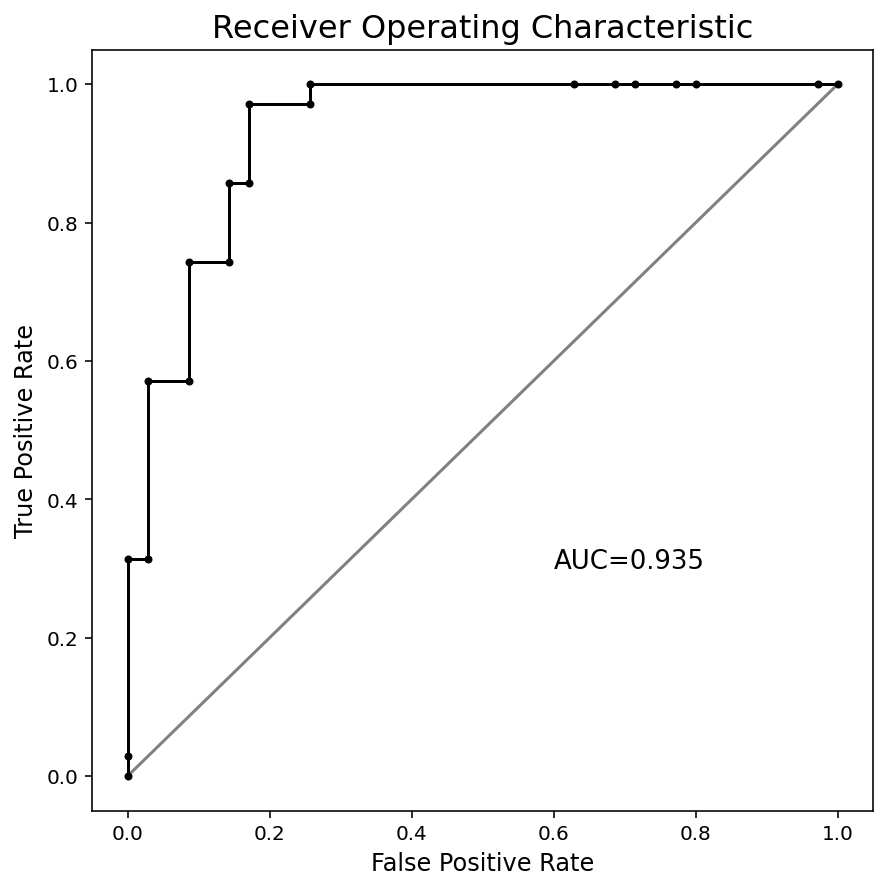

In [127]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = gb_clf2.predict_proba(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

# plt.savefig('Figs/TM_GBC_ROC.png', dpi = 600)

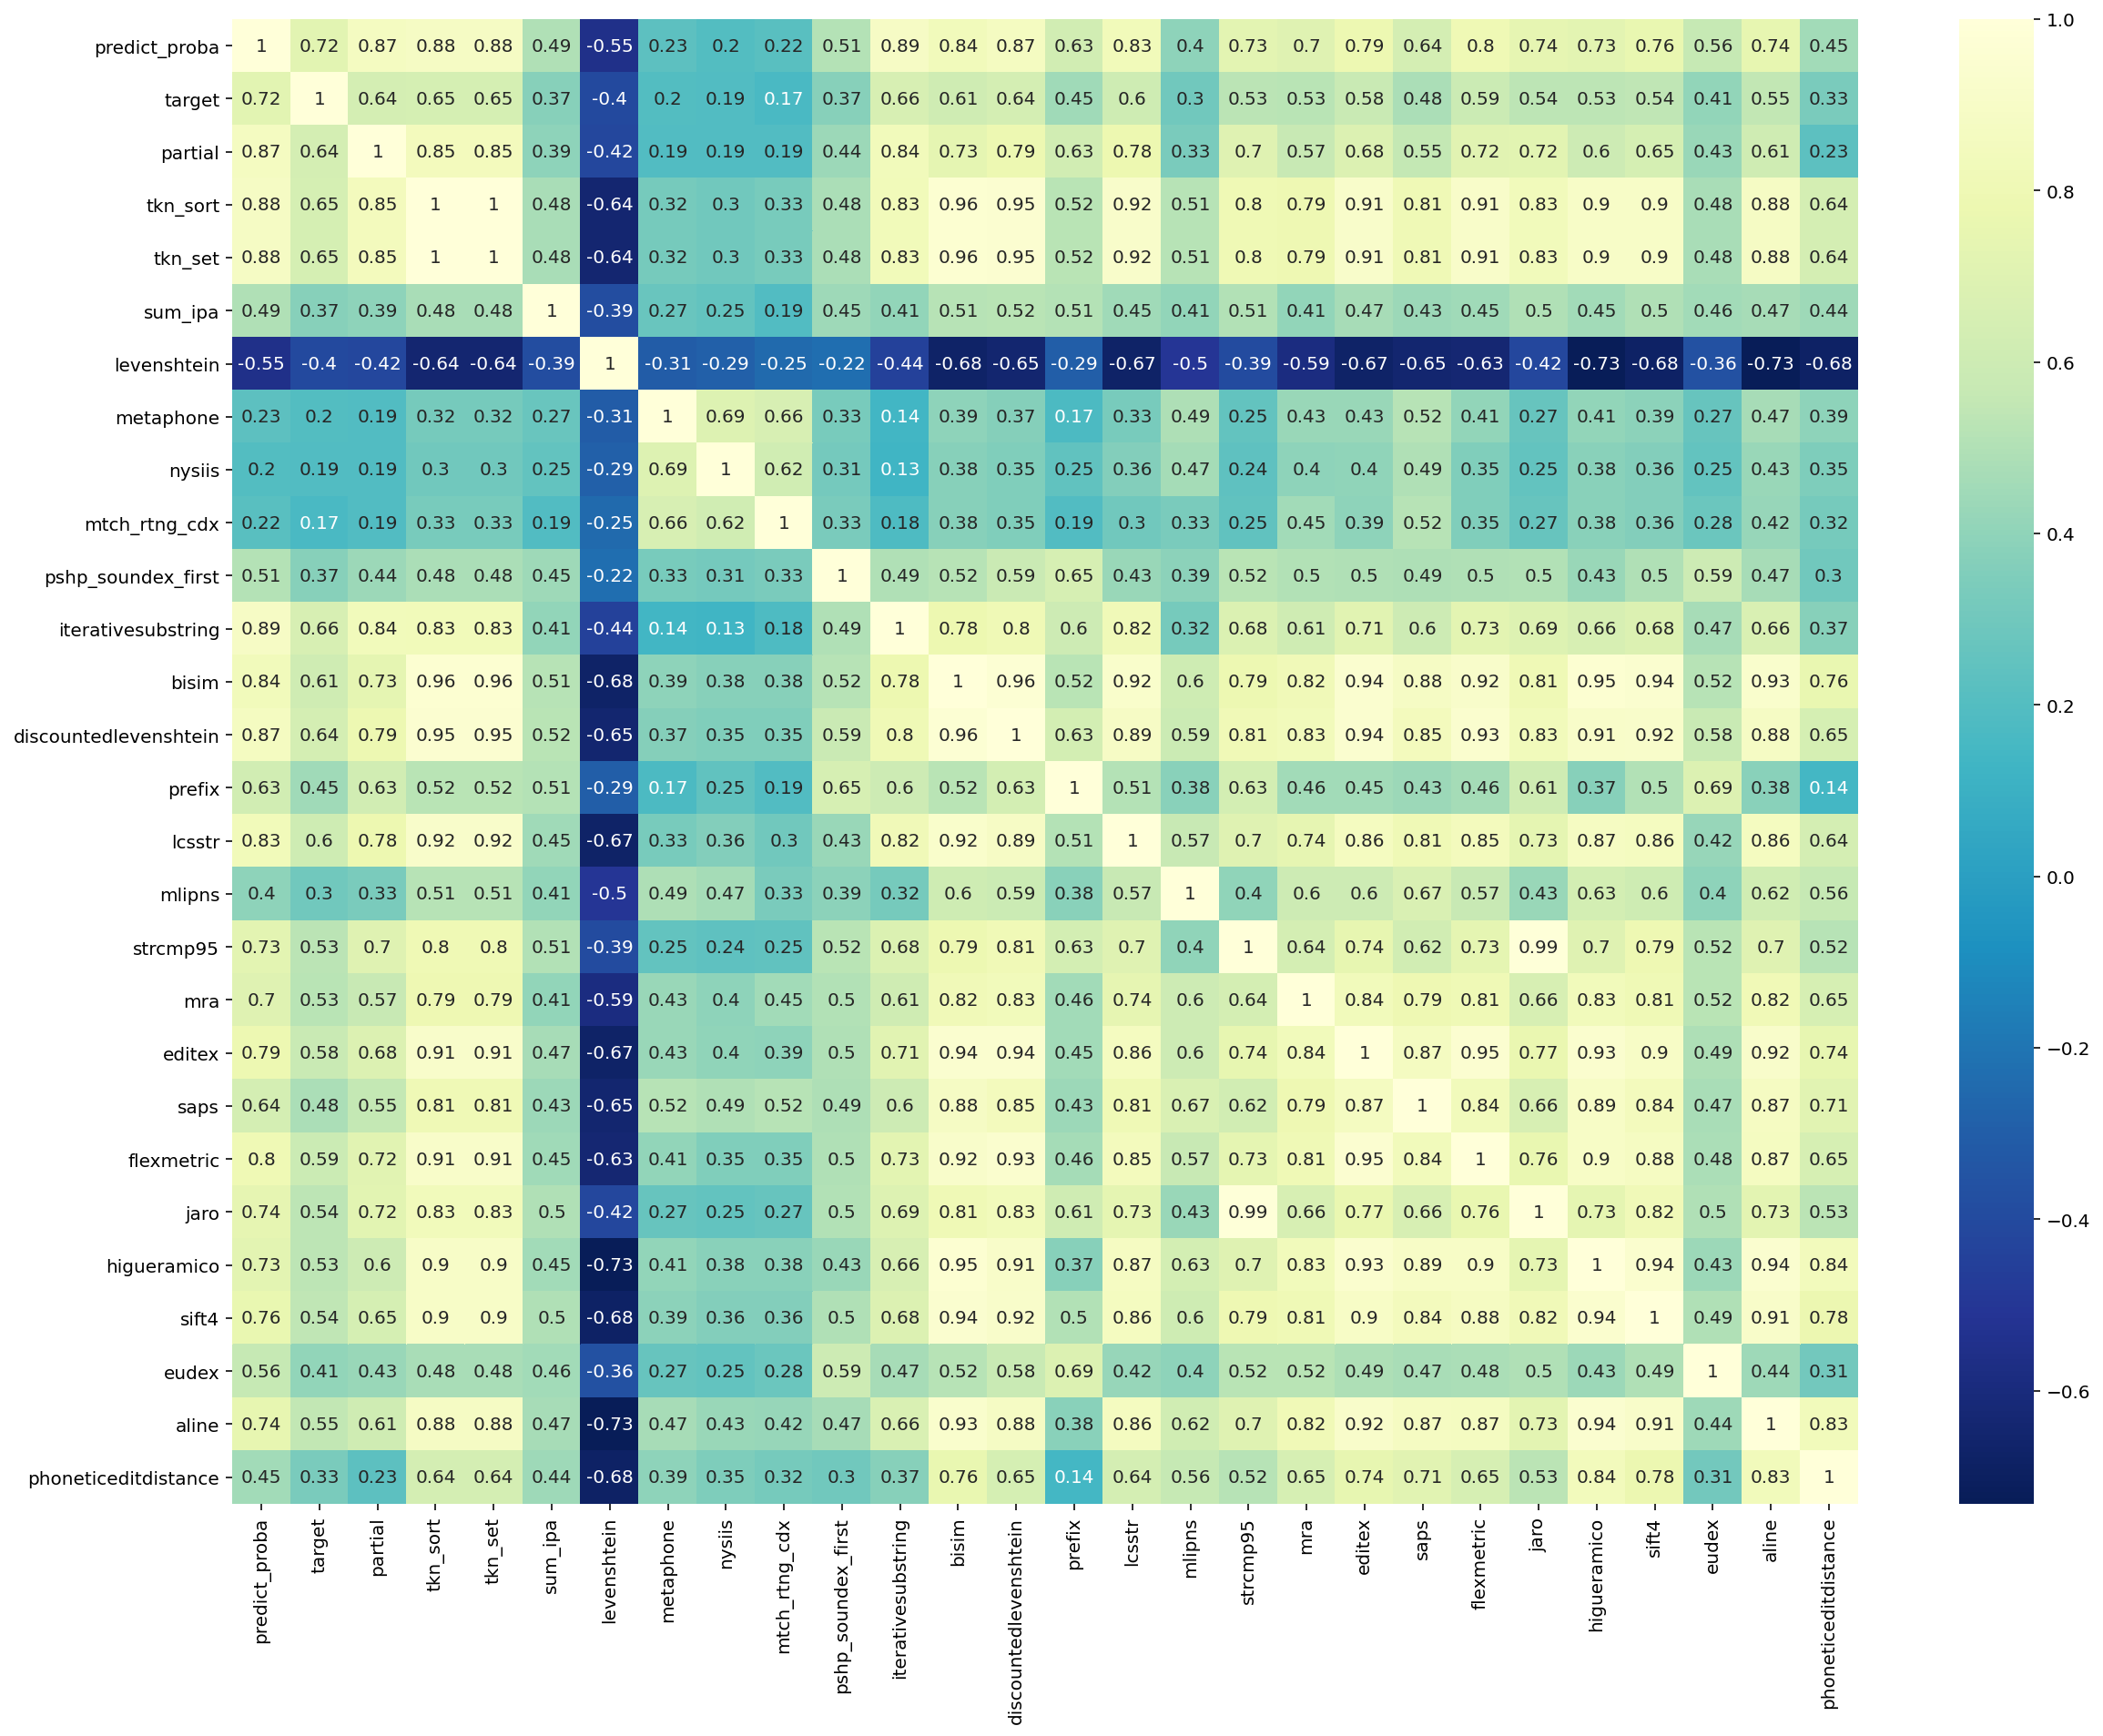

In [128]:
import seaborn as sns

corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot = True,
            cmap="YlGnBu_r")
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# XGboost

In [38]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

y = df.target
X = df.drop(columns = ['target','predict_proba'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [39]:
D_train = xgb.DMatrix(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), label=y_train)
D_test = xgb.DMatrix(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), label=y_test)

param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3}

steps = 20  # The number of training iterations

xgbmodel = xgb.train(param, D_train, steps)

In [40]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = xgbmodel.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.8417734601074824
Recall = 0.8330983078162773
Accuracy = 0.8297872340425532


In [41]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=10)

grid.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_job...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [42]:
import pickle

# Dictionary of best parameters
best_pars = grid.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = grid.best_estimator_
# Save model
pickle.dump(grid.best_estimator_, open("Data.nosync/TM_XGboost_classifier.pkl", "wb"))

### Test saved model

In [43]:
import pickle
import numpy as np

# load the model from disk
loaded_model = pickle.load(open("Data.nosync/TM_XGboost_classifier.pkl", 'rb'))
result = loaded_model.score(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_test)
print(result)

0.8226950354609929


In [44]:
proba_result = loaded_model.predict_proba(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

paa = [p[1] for p in proba_result]

paa




[0.37454507,
 0.8945405,
 0.027230425,
 0.8745826,
 0.017642967,
 0.7186385,
 0.90884346,
 0.015900467,
 0.7103928,
 0.6635003,
 0.62736726,
 0.024256203,
 0.9230927,
 0.94839203,
 0.1377554,
 0.9197192,
 0.015900467,
 0.9225419,
 0.8909921,
 0.80603683,
 0.82621646,
 0.8699378,
 0.7494409,
 0.81766665,
 0.018108489,
 0.47997987,
 0.73622125,
 0.018092968,
 0.6666854,
 0.8991118,
 0.020219987,
 0.11631699,
 0.7819484,
 0.90473825,
 0.4926568,
 0.8485021,
 0.030492192,
 0.9117922,
 0.024788411,
 0.015900467,
 0.90662974,
 0.8806725,
 0.59923995,
 0.828551,
 0.6763884,
 0.7558929,
 0.6918135,
 0.022078443,
 0.811144,
 0.80346155,
 0.018650563,
 0.015573338,
 0.3967574,
 0.9148362,
 0.52362347,
 0.015982436,
 0.020034742,
 0.8752032,
 0.6785932,
 0.75646806,
 0.71271706,
 0.9114373,
 0.024606923,
 0.018294815,
 0.022640688,
 0.014640715,
 0.014640715,
 0.8182341,
 0.029874984,
 0.90577394,
 0.8954039,
 0.020219987,
 0.7548399,
 0.89700156,
 0.01636154,
 0.020958727,
 0.78688884,
 0.883295

In [45]:
loaded_model.predict(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

array([0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1])

In [46]:
# Import pandas library 
import pandas as pd 
  
# initialize list of lists 
data = [['Flipn Chicken','Frickn Chicken']] 
  
# Create the pandas DataFrame 
mydf = pd.DataFrame(data, columns = ['bboyaa', 'fdslkajsdf']) 
  
# print dataframe. 
mydf 

bboyaa      fdslkajsdf
0  Flipn Chicken  Frickn Chicken

In [47]:
featurize(mydf)

a               b          TM_A           TM_B  partial  \
0  Flipn Chicken  Frickn Chicken  flipnchicken  fricknchicken       75   

   tkn_sort  tkn_set   sum_ipa  levenshtein  metaphone  nysiis  mtch_rtng_cdx  \
0        80       80  0.972141          0.0          0       0              0   

   pshp_soundex_first  iterativesubstring     bisim  discountedlevenshtein  \
0                   0            0.761313  0.769231               0.715296   

     prefix    lcsstr  mlipns  strcmp95       mra    editex      saps  \
0  0.083333  0.615385     0.0  0.805192  0.666667  0.846154  0.604167   

   flexmetric      jaro  higueramico     sift4     eudex     aline  \
0    0.815385  0.767521     0.769231  0.769231  0.919608  0.812658   

   phoneticeditdistance  
0              0.899504

In [48]:
foo = featurize(mydf)
foo2 = foo.drop(['a', 'b', 'TM_A', 'TM_B'], 1)

foo3 = loaded_model.predict_proba(foo2)

foo4 = [p[1] for p in foo3]

foo4

[0.8991843]

In [49]:
def XGboost_ratio(data):
    df = featurize(data)
    df2 = df.drop(['a', 'b', 'TM_A', 'TM_B'], 1)
    df3 = loaded_model.predict_proba(df2)
    df4 = [p[1] for p in df3]
    return df4

In [50]:
XGboost_ratio(mydf)

[0.8991843]

In [51]:
import pandas as pd

df = pd.read_csv("Data.nosync/TM_clean_soundex.csv", index_col = False)

# df_matches = df[df.apply(get_ratio, axis = 1) > 70]

# df = df['wordmark']

df.head(5)

wordmark  serial_no soundex       metaphone    nysiis  \
0                  DAISY   70013054    D200              TS      DASY   
1              BUDWEISER   70013064    B326           BTWSR  BADWASAR   
2  WASHBURN'S GOLD MEDAL   70013253    W216  WXBRNS KLT MTL  WASBARN'   
3                  GIANT   70013299    G530             JNT       GAD   
4                WELCOME   70014364    W425            WLKM    WALCAN   

  mtch_rtng_cdx  
0           DSY  
1         BDWSR  
2        WSHMDL  
3           GNT  
4          WLCM

In [52]:


# df.loc[df.str.startswith('f', na=False)]
clean_text = 'flipn chicken'
first_char = clean_text[0]
last_char = clean_text[-6:]

combo = '^' + first_char + '|' + last_char + '$'
# combo = last_char + '$'

combo
# str.contains("^(?:N|M|V|R)")]

df2= df[df['wordmark'].str.contains(combo, na = False)]
# # df.loc[df['wordmark'].str.startswith(first_char, na=False)]

df2

wordmark  serial_no soundex       metaphone    nysiis  \
2319           Char-BQ Chicken   73273996    C612        XRBK XKN    CAR-BG   
3317               frog design   73379800    F623          FRK TS      FRAG   
3918                    filled   73434391    F430             FLT     FALAD   
9545                    female   74041689    F540             FML     FANAL   
9611                       f's   74047650    F200              FS        F'   
...                        ...        ...     ...             ...       ...   
607156         forest lighting   88738126    F623       FRST LTNK    FARAST   
607396                    fung   88740060    F520             FNK      FANG   
607439                  foodie   88740446    F300              FT      FADY   
607532             famecompass   88741687    F525          FMKMPS  FANACANP   
607705  from the North country   88743932    F653  FRM 0 NR0 KNTR      FRAN   

       mtch_rtng_cdx  
2319          CHRCKN  
3317          FRGSGN  
3918             FLD  
9545             FML  
9611             F'S  
...              ...  
607156        FRSTNG  
607396           FNG  
607439            FD  
607532        FMCMPS  
607705        FRMTRY  

[1942 rows x 6 columns]

### Evaluate XGboost

In [53]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

Text(0.6, 0.3, 'AUC=0.858')

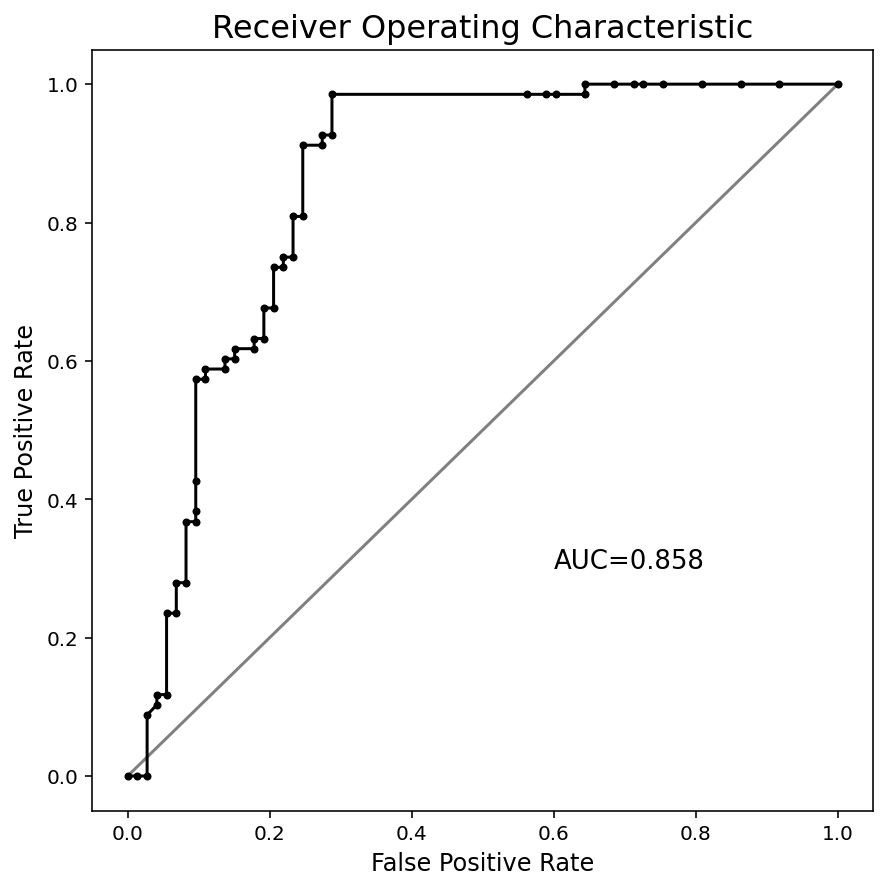

In [54]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = grid.predict_proba(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

# plt.savefig('Figs/TM_XGBoost_ROC.png', dpi = 600)

In [55]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, best_preds))

print("Classification Report")
print(classification_report(y_test, best_preds))

Confusion Matrix:
[[54 19]
 [ 5 63]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.74      0.82        73
           1       0.77      0.93      0.84        68

    accuracy                           0.83       141
   macro avg       0.84      0.83      0.83       141
weighted avg       0.84      0.83      0.83       141



In [56]:
import joblib

xgbmodel.dump_model('Data.nosync/TM_XGBoost_model.pkl')

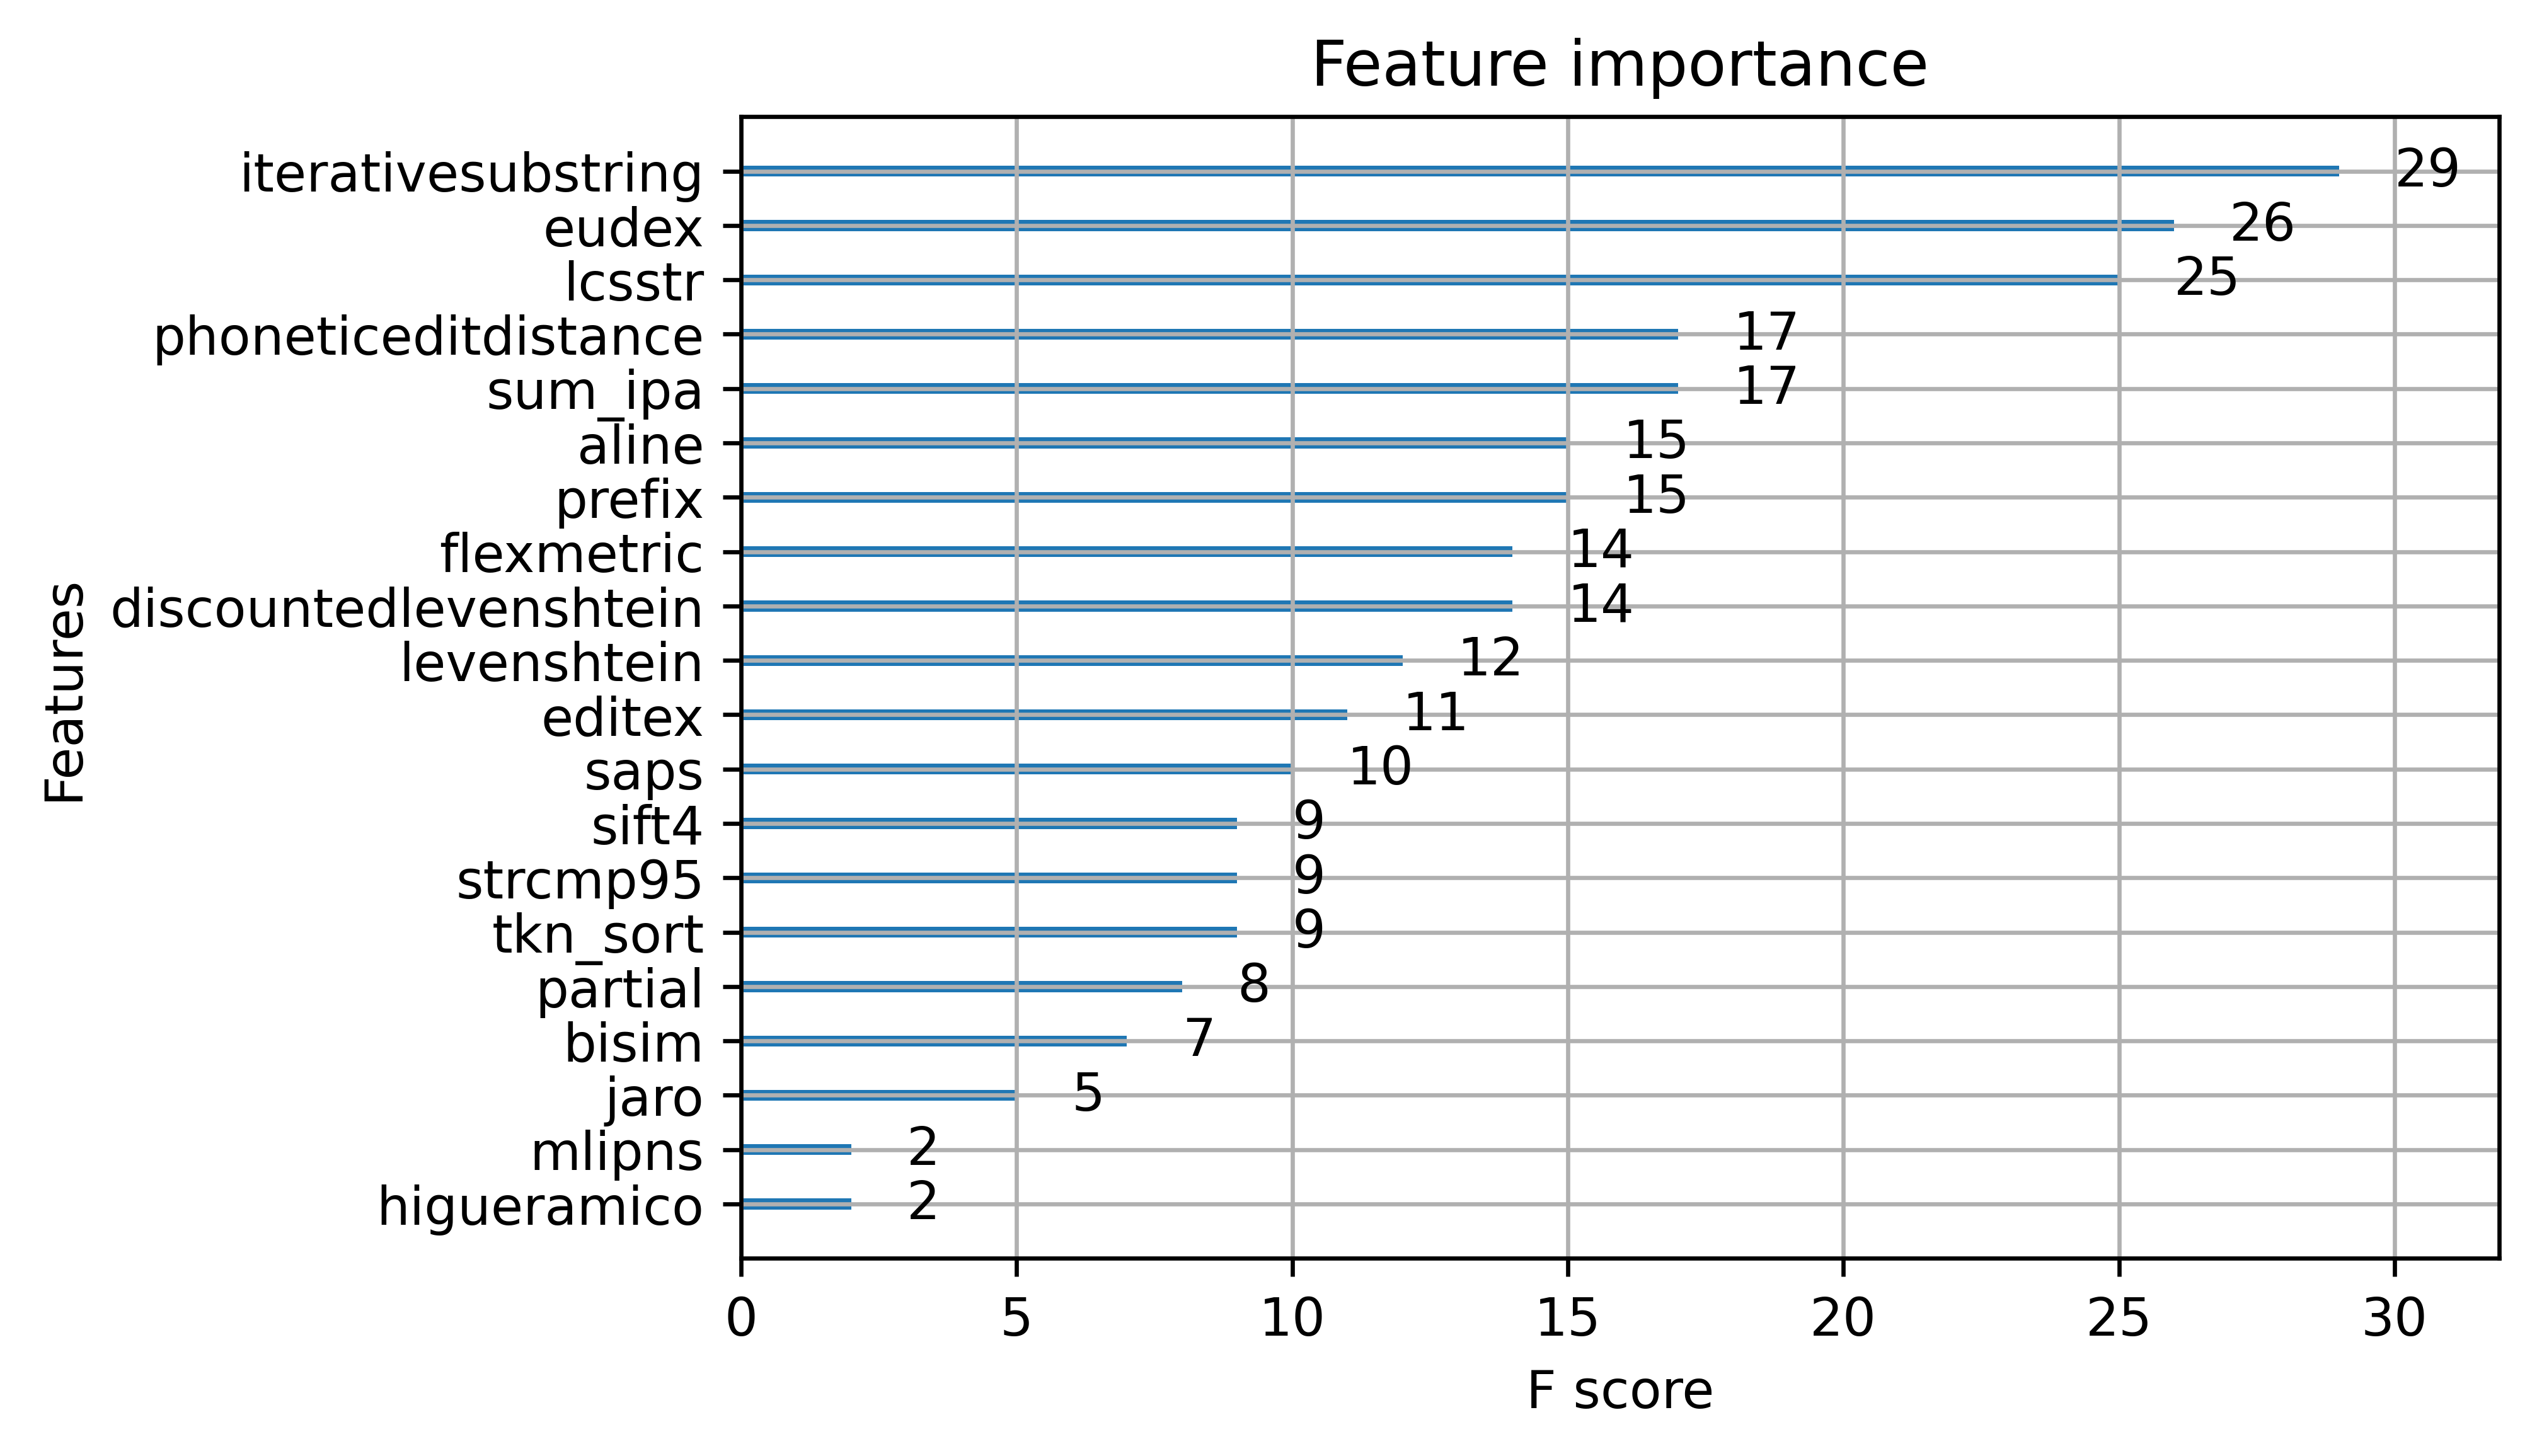

In [57]:
from xgboost import plot_importance
from matplotlib import pyplot

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'

plot_importance(xgbmodel)
# pyplot.show()
# plt.savefig("Figs/TM_XGboost_feature_importance.png", format='png', dpi=600, bbox_inches='tight')

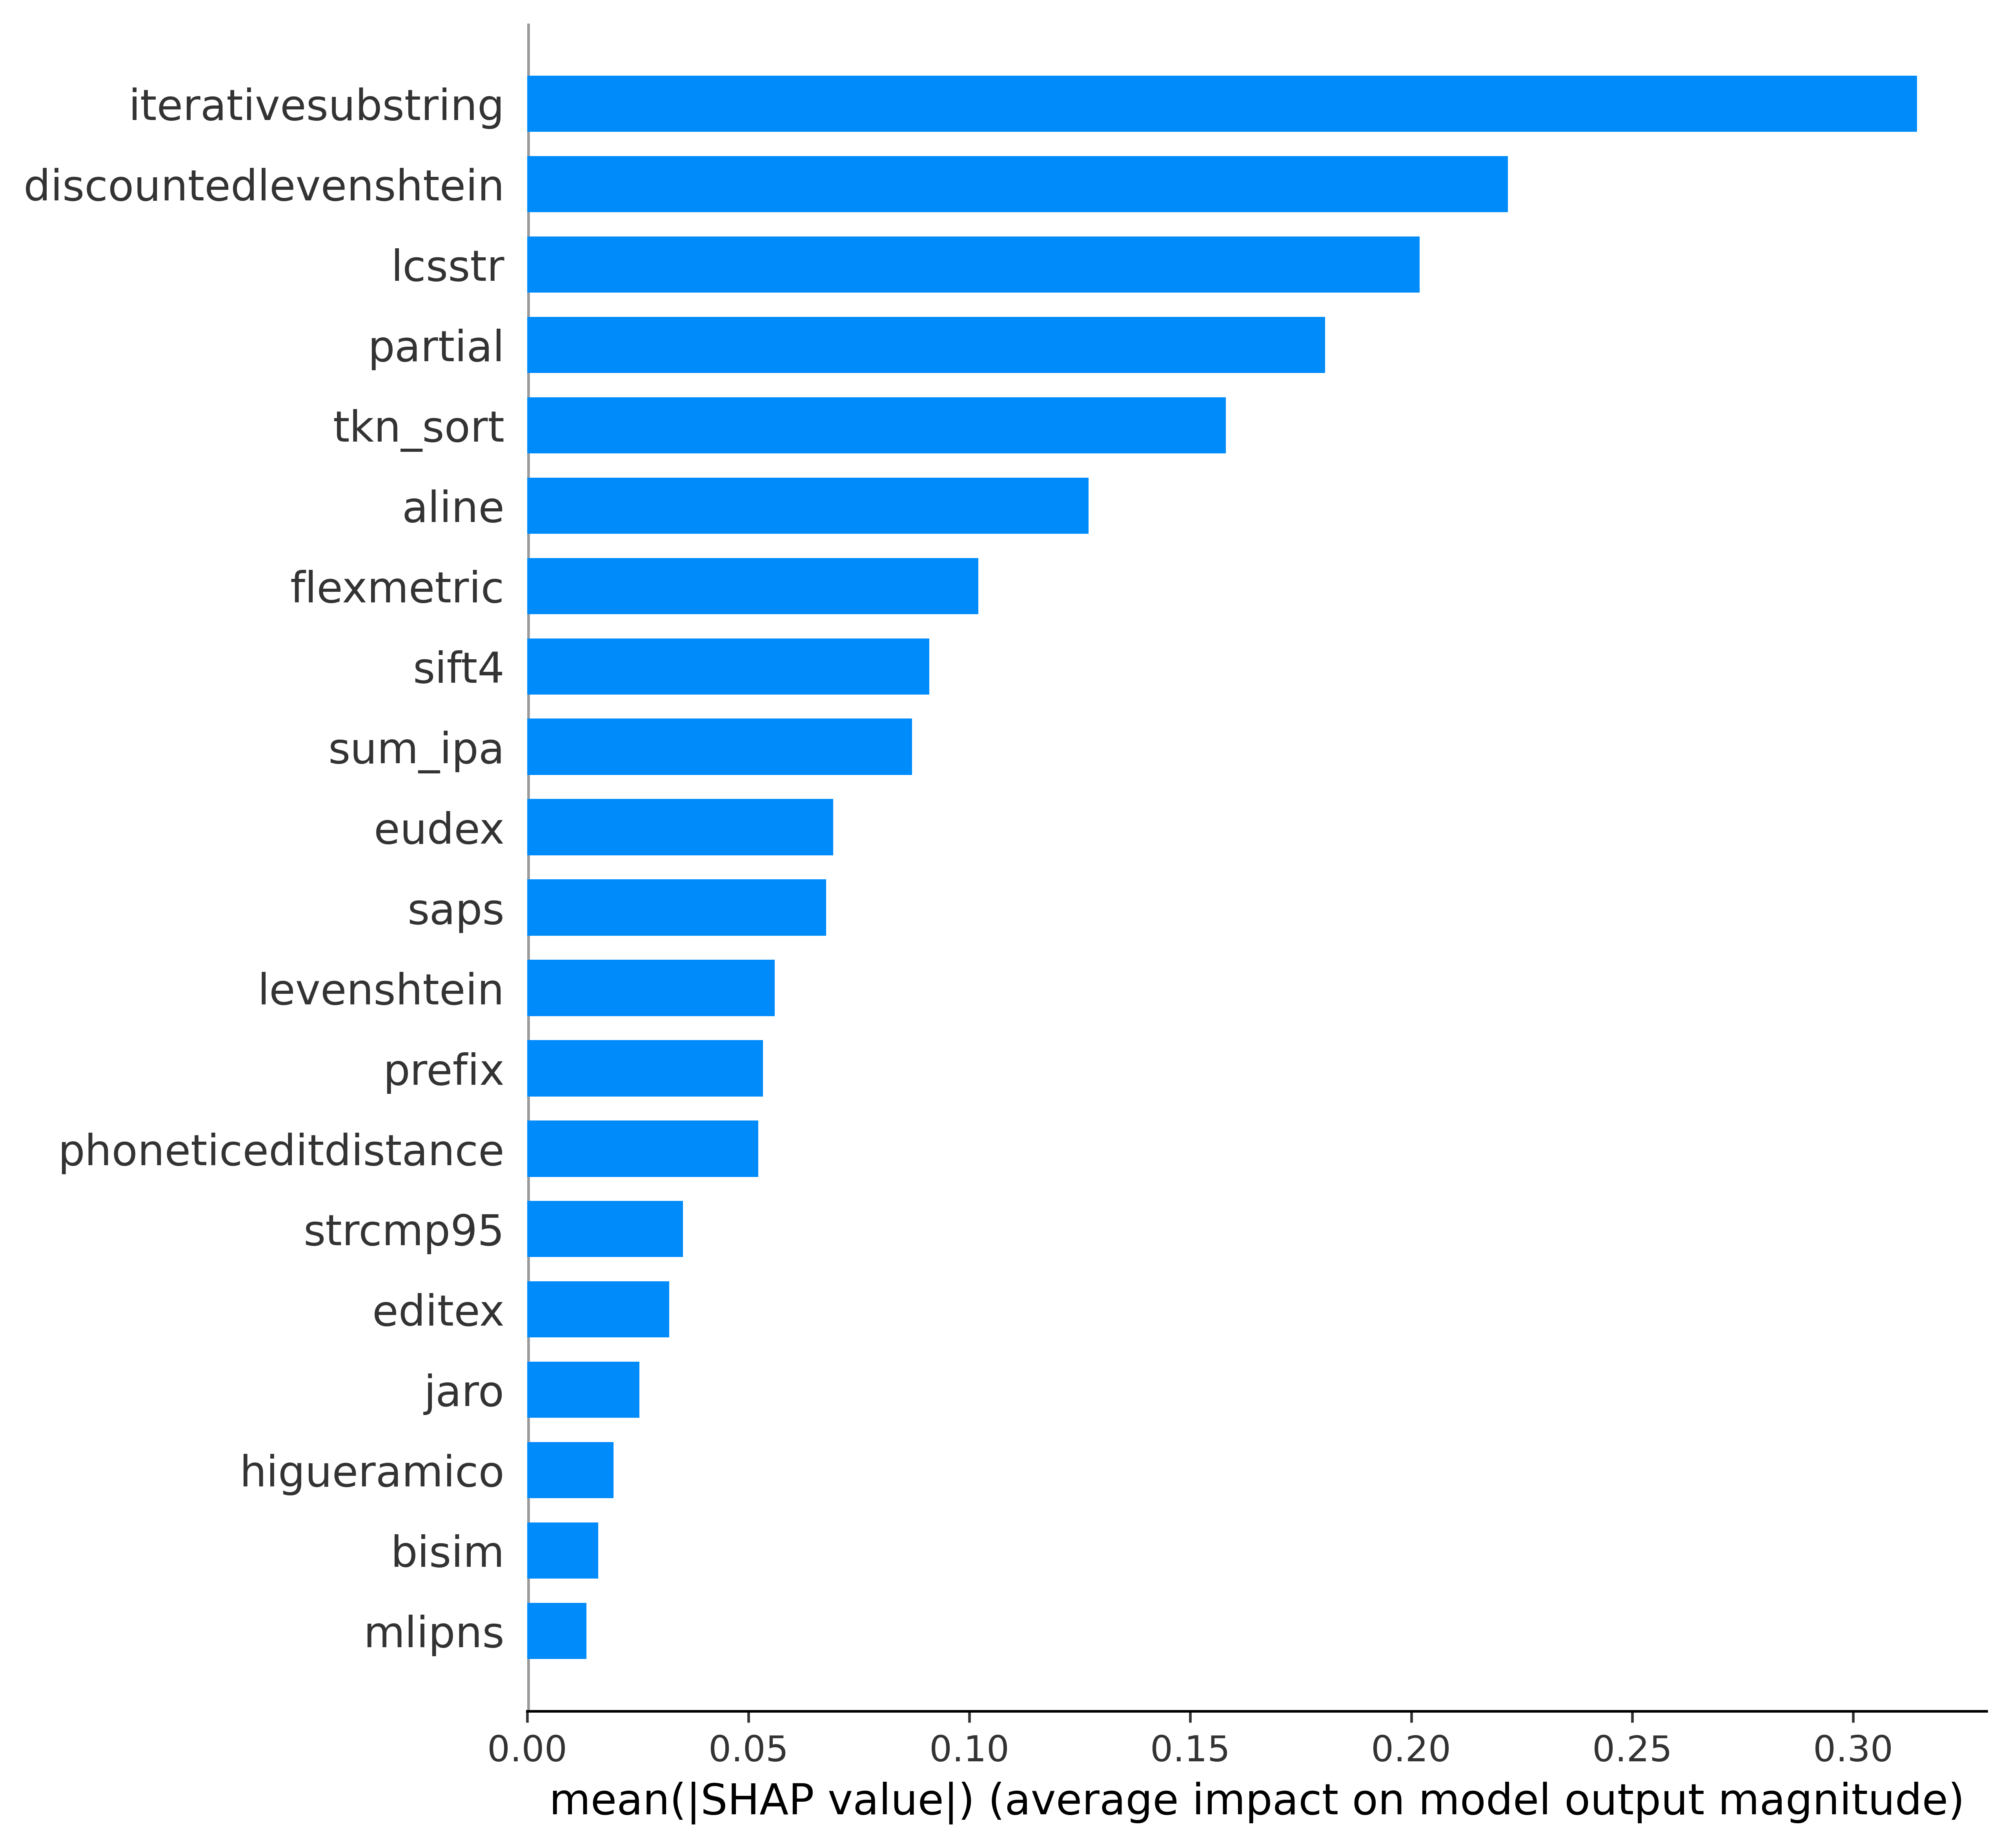

In [58]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(xgbmodel)
shap_values = explainer.shap_values(X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


shap.summary_plot(shap_values[0], X.drop(['a', 'b', 'TM_A', 'TM_B'], 1), plot_type="bar", show=False)
# plt.savefig("Figs/TM_XGboost_SHAP_features.png", format='png', dpi=600, bbox_inches='tight')

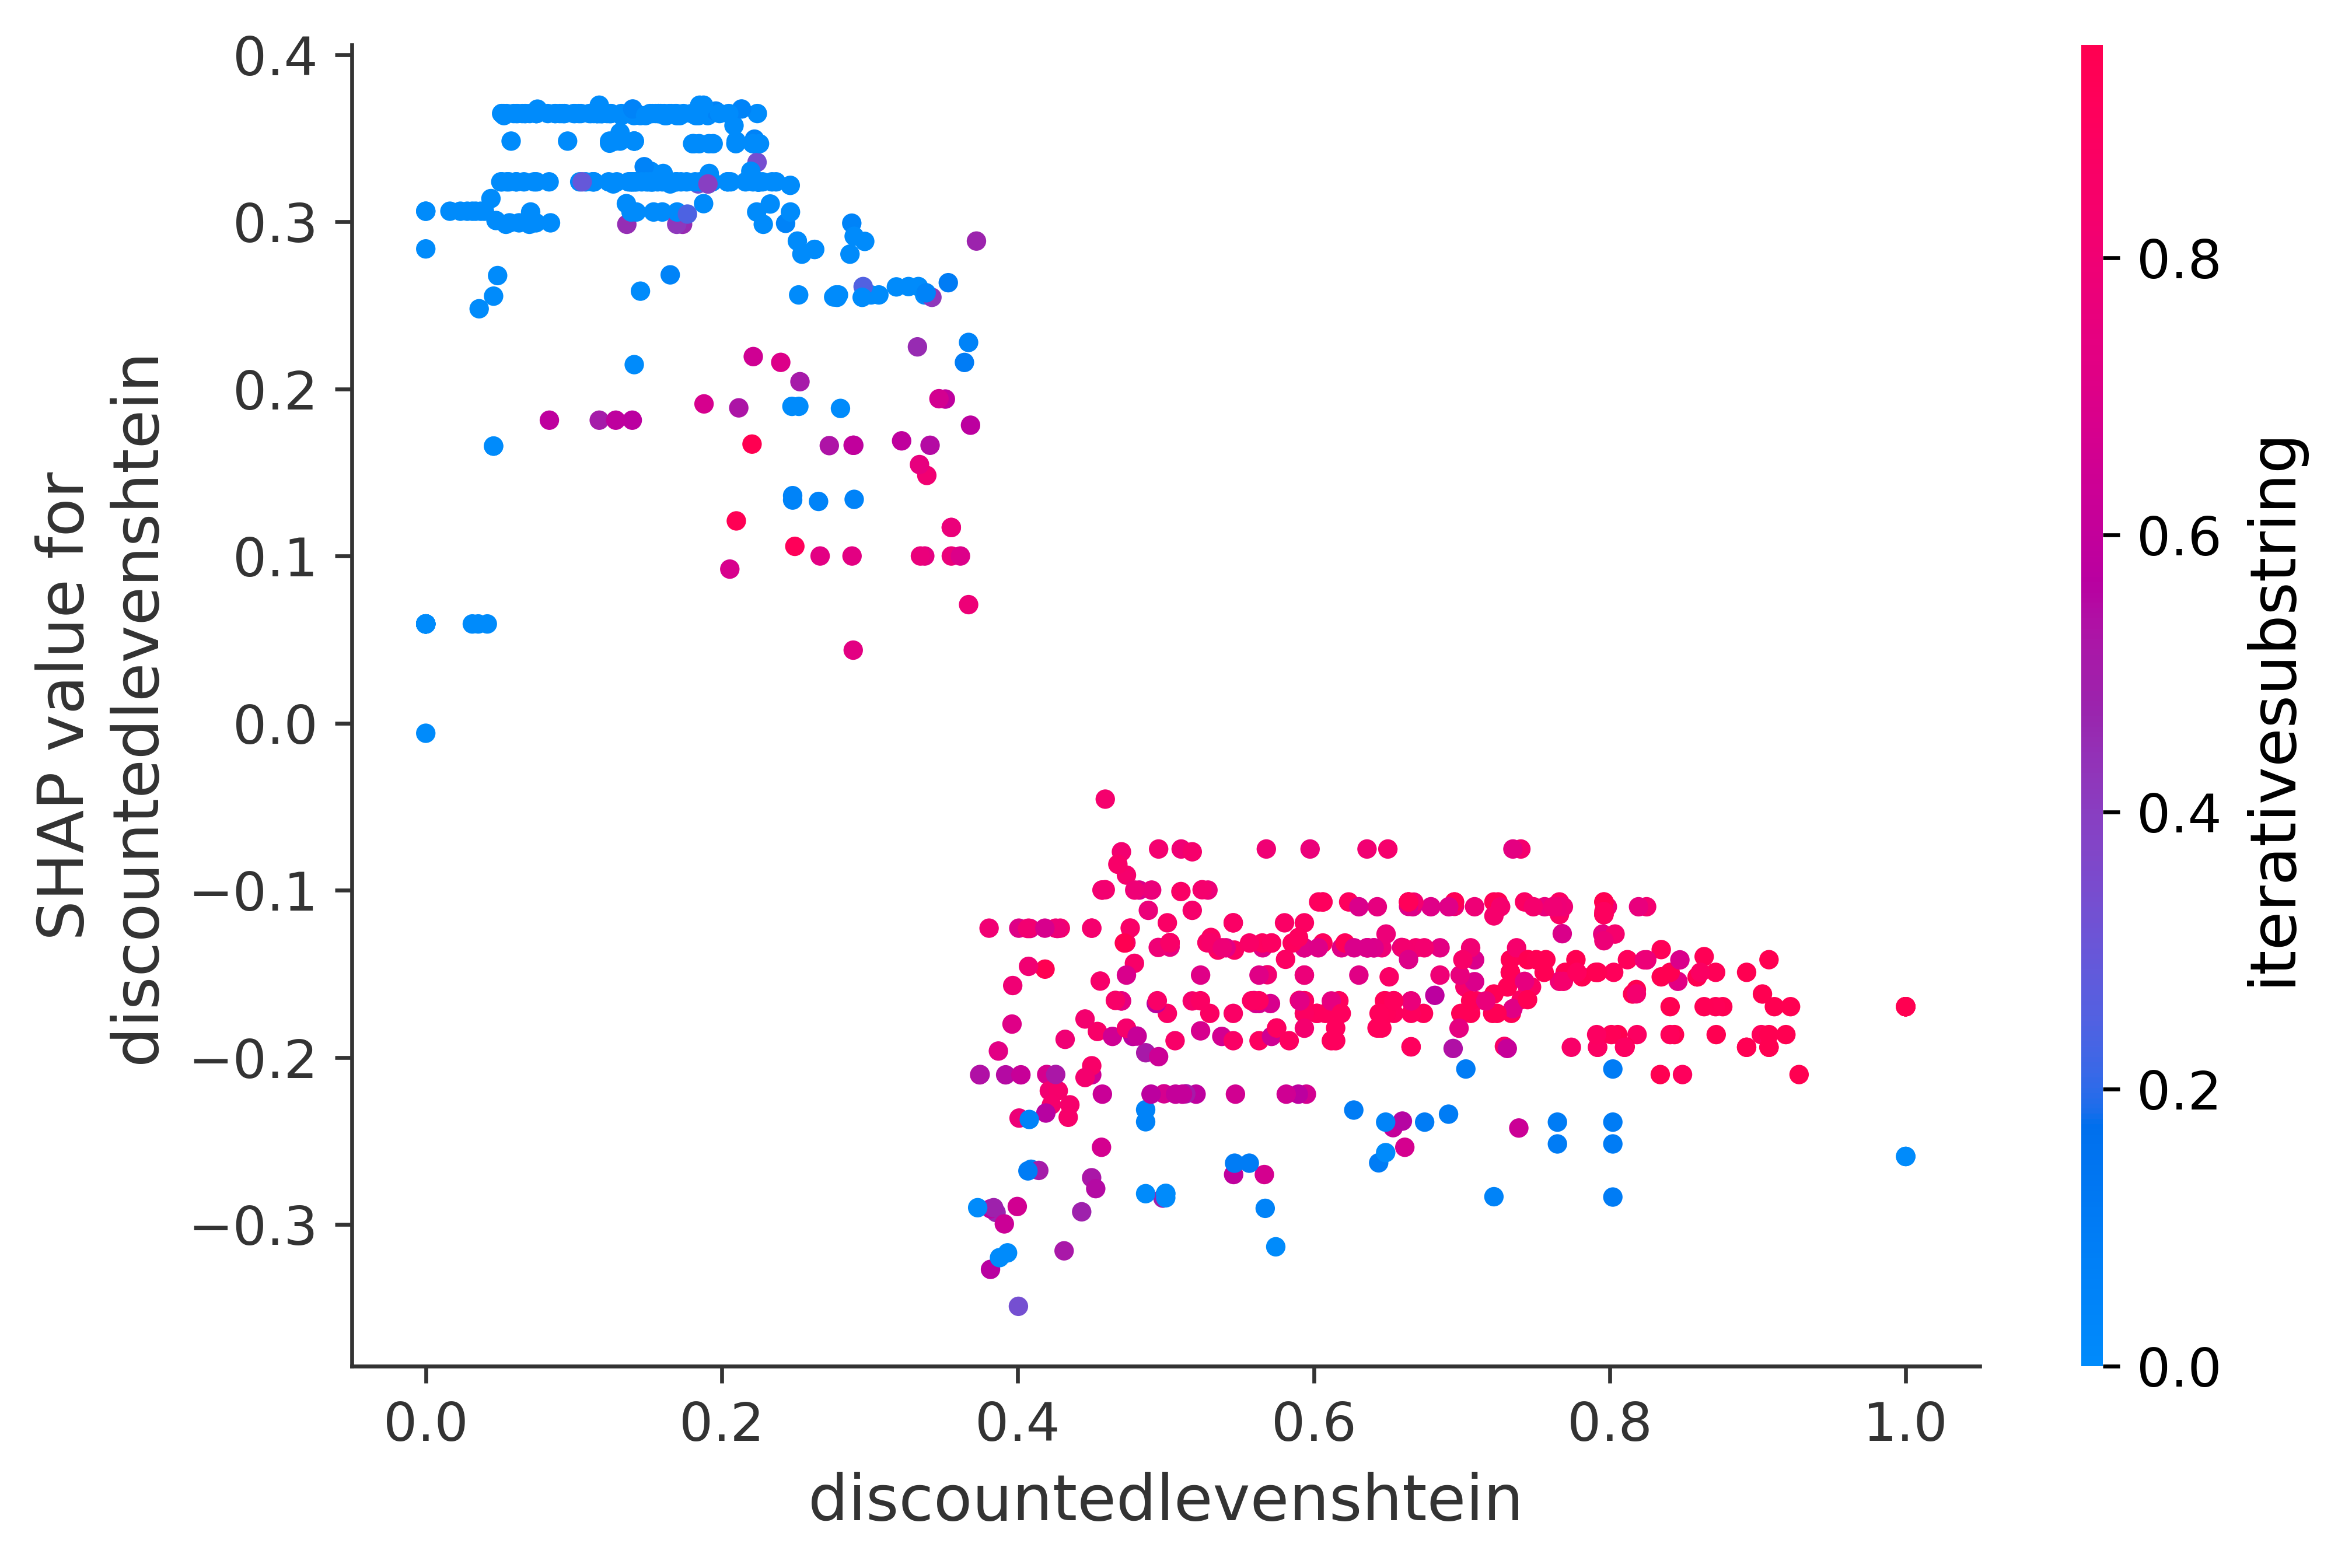

In [59]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("discountedlevenshtein", shap_values[0],
                     X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


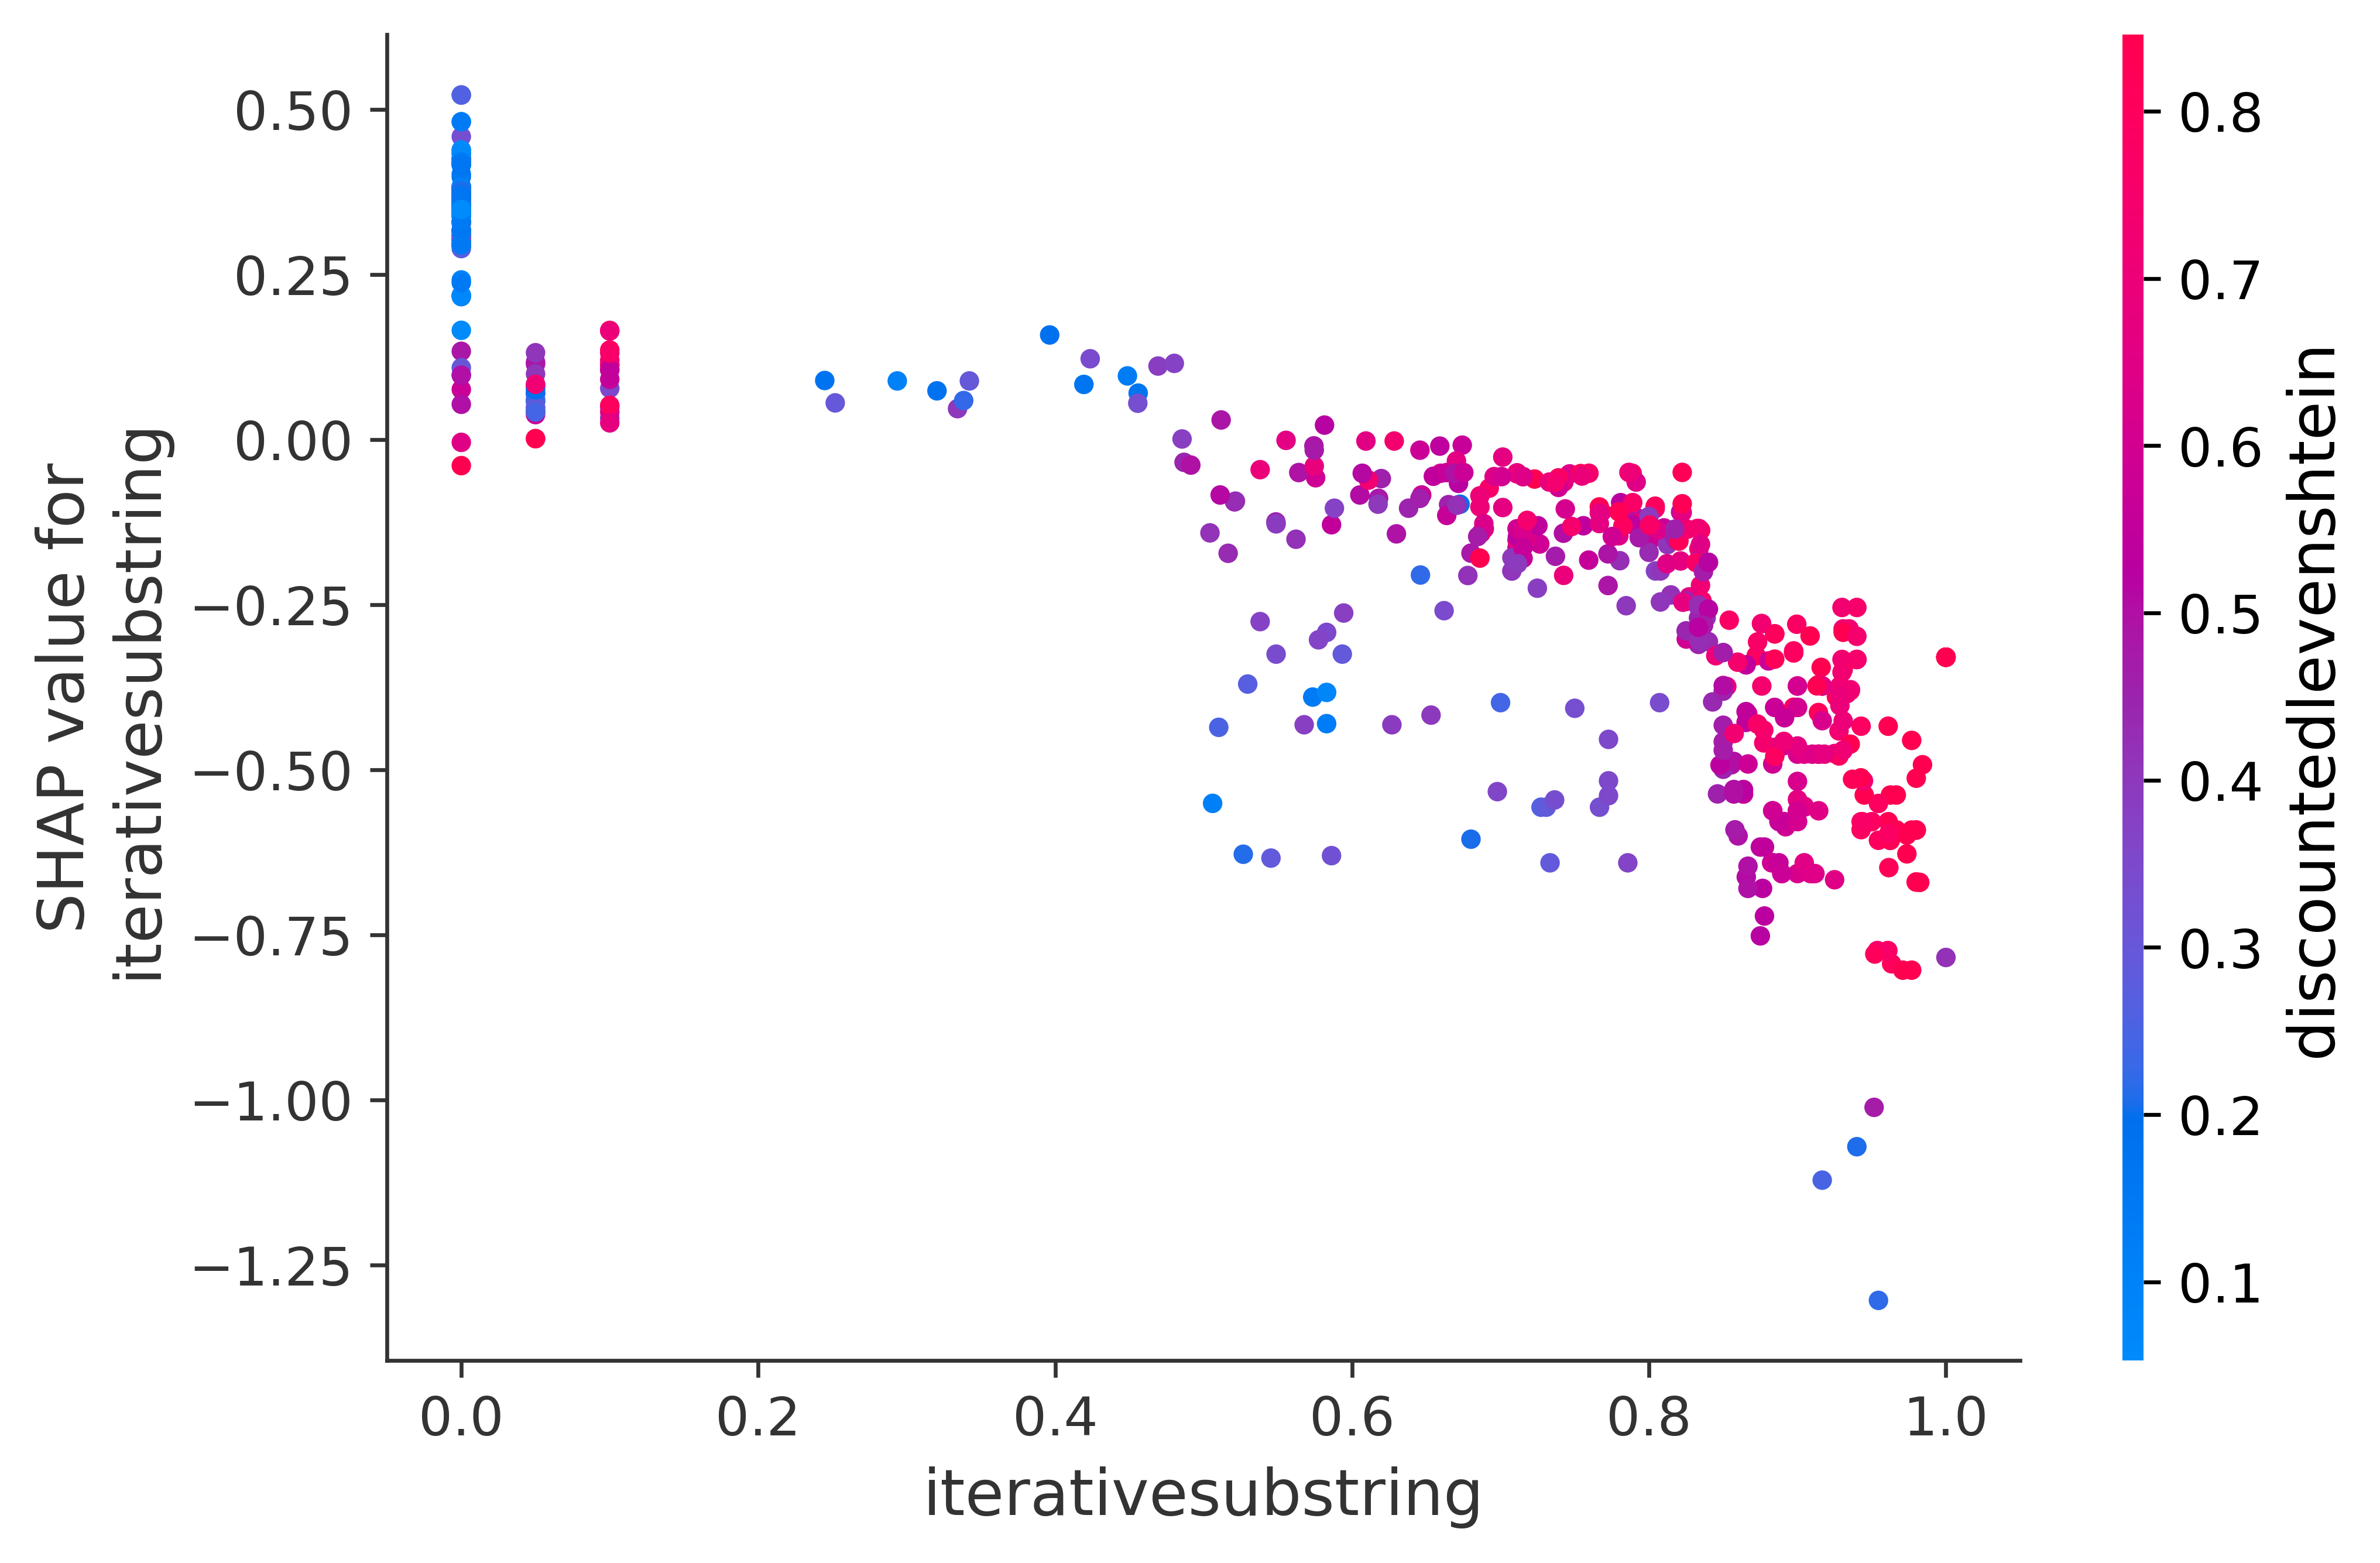

In [60]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("iterativesubstring", shap_values[0],
                     X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


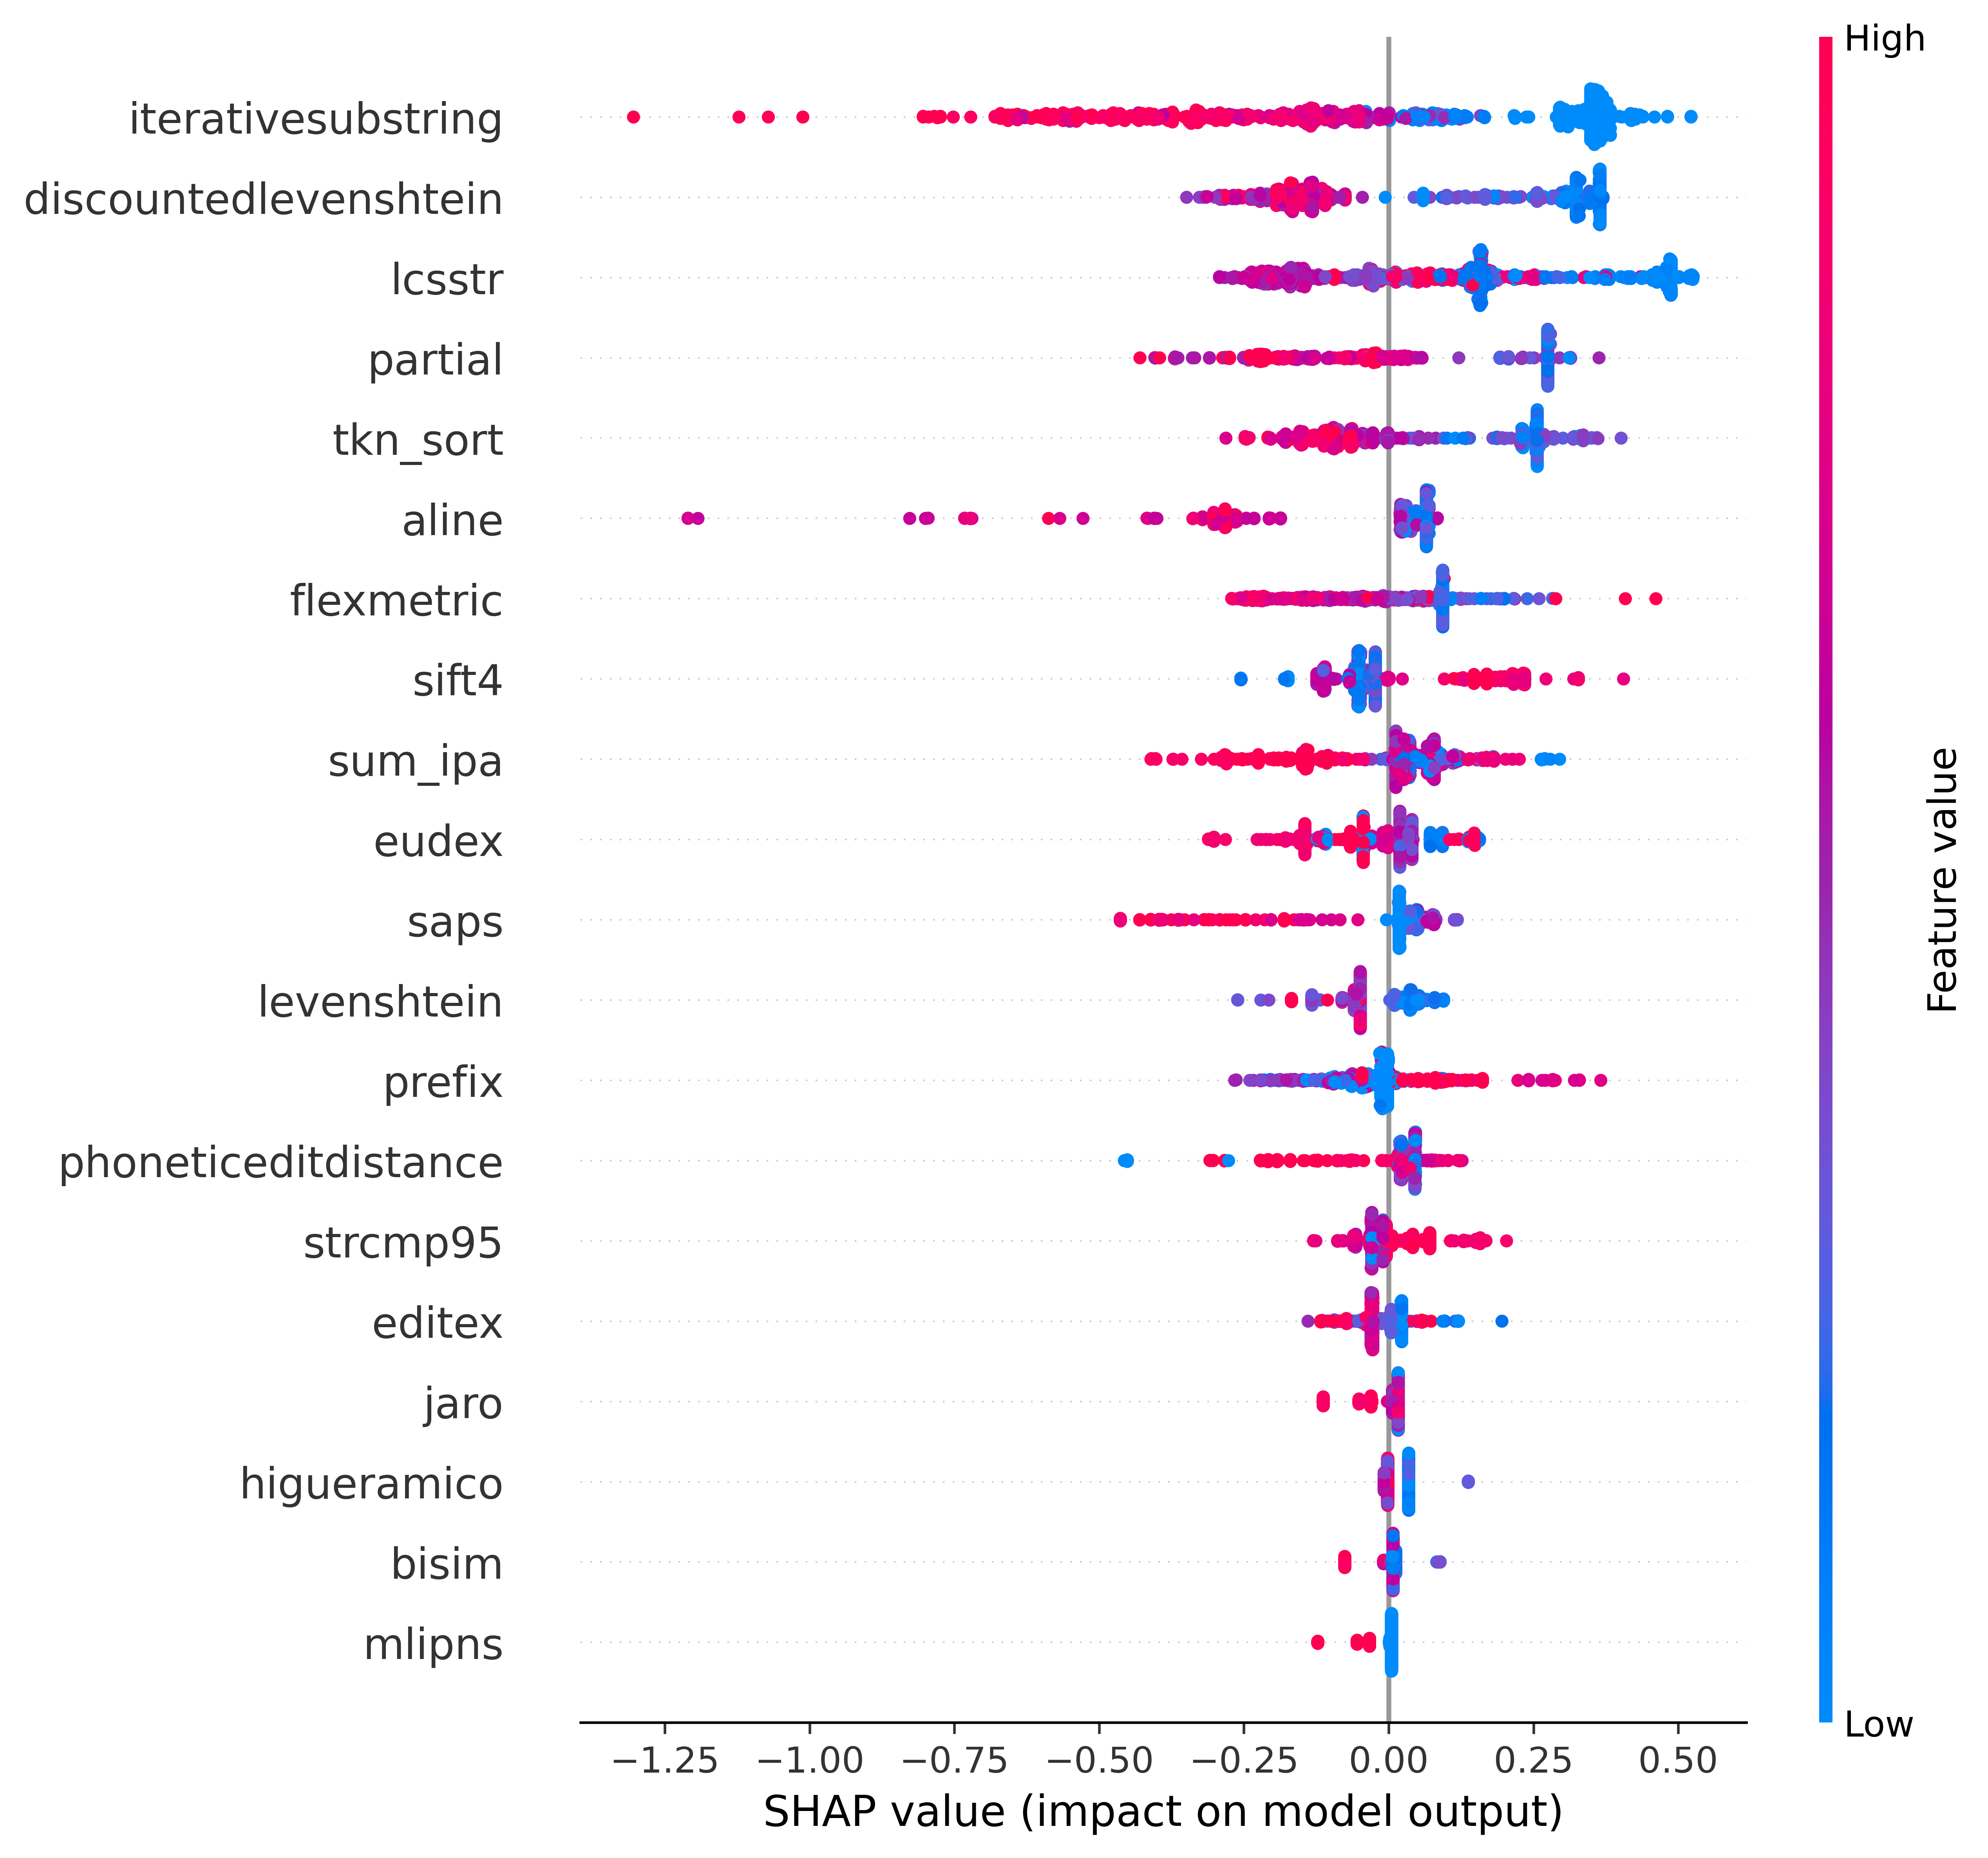

In [61]:
# summarize the effects of all the features
shap.summary_plot(shap_values[0],
                X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

# Grid Search   

Hyperparameter tuning

In [ ]:
cols = [col for col in df.columns if col not in ['a', 'b', 'TM_A', 'TM_B', 'target', 'predict_proba']]
comb2 = list(combinations(cols, 2))
comb3 = list(combinations(cols, 3))
colgrid = [(col,)for col in cols]+comb2+comb3


colgrid

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring = 'precision', verbose=0)

scores = []
for cols in colgrid:
    grid_clf.fit(X_train[['predict_proba']+list(cols)], y_train)
    y_pred = grid_clf.predict(X_val[['predict_proba']+list(cols)])
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    scores.append([str(cols), tn, fp, fn, tp])

In [ ]:
scores_df = pd.DataFrame(scores)

In [ ]:
scores_df.columns = ['features', 'tn', 'fp', 'fn', 'tp']

In [ ]:
scores_df.head()

In [ ]:
scores_df['error'] = scores_df['fp'] + scores_df['fn']

In [ ]:
scores_df = scores_df.sort_values(['error', 'fp'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)

In [ ]:
selected_cols = ['discountedlevenshtein', 'phoneticeditdistance', 'iterativesubstring', 'sum_ipa']

In [ ]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring='precision')
grid_clf.fit(X_train[selected_cols], y_train)
y_pred = grid_clf.predict(X_test[selected_cols])

In [ ]:
print(grid_clf.best_params_)

## Evaluation

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def evaluate(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
    print(classification_report(y_test, y_pred))
    print(conf_matrix)

In [ ]:
evaluate(y_test, y_pred)

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = grid_clf.predict_proba(X_test[selected_cols])
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

### Export Models and Pipeline

In [ ]:
import joblib
import json

In [ ]:
base_1 = base_model_1(X.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y, X_test=None, export=True)
joblib.dump(base_1, filename='Data.nosync/TM_Gradient_boost_base_model.pkl')

In [ ]:
# base_model_2(X[['name_a', 'name_b']], y, X_test=None, export=True)

In [ ]:
joblib.dump(grid_clf.best_estimator_, filename='Data.nosync/TM_meta_model.pkl')